In [2]:
## DeepGBM Development
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib.pyplot as plt

from typing import List
import sys, os
import numpy as np

from deeplift.dinuc_shuffle import dinuc_shuffle
from deeplift.visualization import viz_sequence
import shap
from twobitreader import TwoBitFile

from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)

import loompy
import deepGBM
from tqdm import tqdm, trange

import torch
from torch import nn
import matplotlib.pyplot as plt

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

def one_hot_encoder(enhancers, enhancer_length, f_bit):
    hg38 = TwoBitFile(f_bit)
    enhancer_onehot = np.zeros((len(enhancers), 4, enhancer_length), dtype="float32")
    for ix, enhancer in tqdm(enumerate(enhancers)):
        ch, interval = enhancer.split(":")
        a, b = interval.split("-")
        start = int(a)
        end = int(b)
        seq = hg38[ch][start:end].upper()
        onehot = np.vstack([
            [s == "A" for s in seq],
            [s == "C" for s in seq],
            [s == "G" for s in seq],
            [s == "T" for s in seq]
        ])
        enhancer_onehot[ix, :, :] = onehot
    return enhancer_onehot

shap.explainers._deep.deep_pytorch.op_handler["Flatten"] = shap.explainers._deep.deep_pytorch.linear_1d
shap.explainers._deep.deep_pytorch.op_handler["Select"] = shap.explainers._deep.deep_pytorch.linear_1d
shap.explainers._deep.deep_pytorch.op_handler["GELU"] = shap.explainers._deep.deep_pytorch.nonlinear_1d
shap.explainers._deep.deep_pytorch.op_handler["SiLU"] = shap.explainers._deep.deep_pytorch.nonlinear_1d

def shuffle_several_times(x):
    # x.shape == (length, 4)
    # Returns (100, 4, length)
    if (x is None):
        return torch.tensor(np.zeros((100, 4, 249)).astype("float32"))
    else:
        return torch.tensor(np.array([dinuc_shuffle(x.T).T for i in range(100)]).astype("float32"))
    
#This combine_mult_and_diffref function can be used to generate hypothetical
# importance scores for one-hot encoded sequence.
#Hypothetical scores can be thought of as quick estimates of what the
# contribution *would have been* if a different base were present. Hypothetical
# scores are used as input to the importance score clustering algorithm
# TF-MoDISco (https://github.com/kundajelab/tfmodisco)
# Hypothetical importance scores are discussed more in this pull request:
#  https://github.com/kundajelab/deeplift/pull/36
def combine_mult_and_diffref(mult, orig_inp, bg_data):
    to_return = []
    # Originally for inputs that are in the format (length x 4)
    mult = mult.T
    orig_inp = orig_inp.T
    bg_data = bg_data.T
    for l in range(len(mult)):
        #At each position in the input sequence, we iterate over the one-hot encoding
        # possibilities (eg: for genomic sequence, this is ACGT i.e.
        # 1000, 0100, 0010 and 0001) and compute the hypothetical 
        # difference-from-reference in each case. We then multiply the hypothetical
        # differences-from-reference with the multipliers to get the hypothetical contributions.
        #For each of the one-hot encoding possibilities,
        # the hypothetical contributions are then summed across the ACGT axis to estimate
        # the total hypothetical contribution of each position. This per-position hypothetical
        # contribution is then assigned ("projected") onto whichever base was present in the
        # hypothetical sequence.
        #The reason this is a fast estimate of what the importance scores *would* look
        # like if different bases were present in the underlying sequence is that
        # the multipliers are computed once using the original sequence, and are not
        # computed again for each hypothetical sequence.
        projected_hypothetical_contribs = np.zeros((4,4)).astype("float")
        assert len(orig_inp[l].shape)==2, orig_inp[l].shape
        for i in range(4):
            hypothetical_input = np.zeros(4).astype("float")
            hypothetical_input[i] = 1.0
#             hypothetical_difference_from_reference = (hypothetical_input[None,:,:]-bg_data[l])
            hypothetical_difference_from_reference = (hypothetical_input-bg_data[l].T)
            hypothetical_contribs = hypothetical_difference_from_reference*mult[l]
            projected_hypothetical_contribs[:,i] = np.sum(hypothetical_contribs,axis=-1)
        to_return.append(np.mean(projected_hypothetical_contribs,axis=0))
    return np.array(to_return).T

def compute_contrib(cfname, pred_sequences):
    model = deepGBM.ConvolutionalClassificationModel.load_from_checkpoint(cfname, map_location=torch.device('cpu'))
    model.eval()
    explainer = DeepLiftShap(model)

    contrib_scores= []
    norm_scores = []
    for i in trange(len(pred_sequences)):
        onehot_data = pred_sequences[i].numpy()
        explanations = explainer.attribute(torch.tensor(onehot_data[None, :, :]), shuffle_several_times(onehot_data), target=1).detach().numpy()[0]
        dinuc_shuff_explanation = np.sum(explanations, axis=0) * onehot_data
        norm = dinuc_shuff_explanation - np.mean(dinuc_shuff_explanation,axis=0)[np.newaxis,:]
        contrib_scores.append(dinuc_shuff_explanation)
        norm_scores.append(norm)
        
    return contrib_scores, norm_scores

/home/camiel/anaconda3/envs/deepGBM/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# build = '/proj/DEV_ATAC/submission/Purkinje_lineage/'
# s = 'Purkinje'
# f_peaks = os.path.join(build, f'{s}_peaks.loom')
# f_RNA = os.path.join(build, f'{s}_RNA.loom')

# emb = 'UMAP'

# data_dir = '/proj/DEV_ATAC/ML_dev/20230125_submission/torch_data/'
# cfname = "/proj/DEV_ATAC/ML_dev/20230125_submission/lightning_logs/CNN_deepGBM/version_0/checkpoints/epoch=26-step=3375.ckpt"
# f = '/proj/DEV_ATAC/ML_dev/20230125_submission/Pool_subset/Pool_subset.agg.loom'


In [2]:
from pybedtools import BedTool
peaks = BedTool('/proj/DEV_ATAC/Build_20220906_classes/All/peaks/Compounded_peaks.bed')
SNPs = BedTool('/proj/DEV_ATAC/submission/GWAS_analysis/sig_snps.bed')
SNPs_extended = SNPs.slop(g = '/home/camiel/chromograph/chromograph/references/male.GRCh38.chrom.sizes',l=200, r=200).saveas('/proj/DEV_ATAC/submission/GWAS_analysis/sig_snps_extended.bed')

valid_peaks = peaks.intersect(SNPs, wo=True)
enhancers = [x[3] for x in valid_peaks]
print(valid_peaks.count())
valid_peaks.head()

34
chr1	73310738	73311139	chr1:73310738-73311139	.	+	chr1	73311013	73311014	rs6424547	2.796e-08	.	1
 chr1	73377397	73377798	chr1:73377397-73377798	.	+	chr1	73377530	73377531	rs7516608	4.921e-08	.	1
 chr14	41605167	41605568	chr14:41605167-41605568	.	+	chr14	41605523	41605524	rs61990288	4.733e-08	.	1
 chr5	104342860	104343261	chr5:104342860-104343261	.	+	chr5	104343004	104343005	rs349586	5.897e-09	.	1
 chr5	104400953	104401354	chr5:104400953-104401354	.	+	chr5	104401101	104401102	rs13162928	1.347e-09	.	1
 chr5	104540440	104540841	chr5:104540440-104540841	.	+	chr5	104540492	104540493	rs1363096	8.638e-09	.	1
 chr5	104611236	104611637	chr5:104611236-104611637	.	+	chr5	104611504	104611505	rs2447828	4.398e-09	.	1
 chr5	104611993	104612394	chr5:104611993-104612394	.	+	chr5	104612267	104612268	rs2431108	1.689e-09	.	1
 chr5	104611993	104612394	chr5:104611993-104612394	.	+	chr5	104612344	104612345	rs2447827	7.397e-09	.	1
 chr6	26365033	26365434	chr6:26365033-26365434	.	+	chr6	26365358	26365359	rs

In [1]:
SNPs_extended.head()

NameError: name 'SNPs_extended' is not defined

In [79]:
from sklearn.metrics import roc_auc_score
import glob
from sklearn.metrics import roc_curve

colors = ["#B36305", "#E32017", "#FFD300", "#00782A",
          "#F3A9BB"]

f = '/proj/DEV_ATAC/ML_dev/20230125_submission/Pool_subset/Pool_subset.agg.loom'

with loompy.connect(f) as ds:
    ClusterNames = ds.ca.ClusterName
    print(ClusterNames)
    
# files = [os.path.join(data_dir, f'{x}_set.pt') for x in ['pred', 'test', 'training']]
# sequences, true_labels = [], []
# for f in files:
#     data = torch.load(f) ## pred_set
#     sequences.append(torch.tensor(np.array([x[0].numpy() for x in data])))
#     true_labels.append(np.array([x[1] for x in data]).astype(int))
       
# files = [os.path.join(data_dir, f'{x}_names.npy') for x in ['pred', 'test', 'training']]
# names = []
# for f in files:
#     data = np.load(f) ## pred_set
#     names.append(data)
# names = [x for s in names for x in s]

['CB_Exc' 'HB_Exc' 'Tel_Exc' 'MB_Inh' 'Purkinje']


In [21]:
with loompy.connect(f) as ds:
#     print(ds.layers.keys())
#     for inter in valid_peaks:
#         x = np.where(ds.ra.ID==inter[3])[0]
#         plt.figure(figsize=(3,1))
#         plt.scatter(np.arange(5), ds['CPM'][x,:])
#         plt.ylim([0, 1.1*np.max(ds['CPM'][x,:])])
        
    res = np.zeros([len(valid_peaks), 5])
    for i, inter in enumerate(valid_peaks):
        x = np.where(ds.ra.ID==inter[3])[0]
        res[i,:] = ds['CPM'][x,:]
        
valid = res[:,3] > (np.max(res, 1) * .75)
from collections import Counter

Counter(np.argmax(res,1))

Counter({0: 6, 2: 4, 3: 12, 4: 9, 1: 3})

In [32]:
f_bit = '/datb/sl/camiel/tumor/Enhancer_training/files/hg38.2bit'
cfname = "/proj/DEV_ATAC/ML_dev/20230125_submission/lightning_logs/CNN_deepGBM/version_0/checkpoints/epoch=26-step=3375.ckpt"

## Enhancers to annotate
sequences = one_hot_encoder(enhancers, 401, f_bit)

hypo_contributions = []
contrib_scores= []
norm_scores = []

model = deepGBM.ConvolutionalClassificationModel.load_from_checkpoint(cfname, map_location=torch.device('cpu'))
model.eval()
explainer = DeepLiftShap(model)

labels = np.repeat(3, len(sequences))
for i in trange(len(sequences)):
    onehot_data = sequences[i]
    mult = explainer.attribute(torch.tensor(onehot_data[None, :, :]), shuffle_several_times(onehot_data), target=int(labels[i])).detach().numpy()[0]
    bg_data = np.mean(shuffle_several_times(onehot_data).numpy(),axis=0)

    hypo = combine_mult_and_diffref(mult, orig_inp=torch.tensor(onehot_data[None, :, :]), bg_data=bg_data)
    hypo_contributions.append(hypo)
    
    dinuc_shuff_explanation = np.sum(mult, axis=0) * onehot_data
    norm = dinuc_shuff_explanation - np.mean(dinuc_shuff_explanation,axis=0)[np.newaxis,:]
    contrib_scores.append(dinuc_shuff_explanation)
    norm_scores.append(norm)

34it [00:00, 3396.76it/s]
  0%|          | 0/34 [00:00<?, ?it/s]Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
An invalid module MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) is detected. Saved gradients will
                be used as the gradients of the module's input tensor.
                See MaxPool1d as an example.
100%|██████████| 34/34 [01:02<00:00,  1.83s/it]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


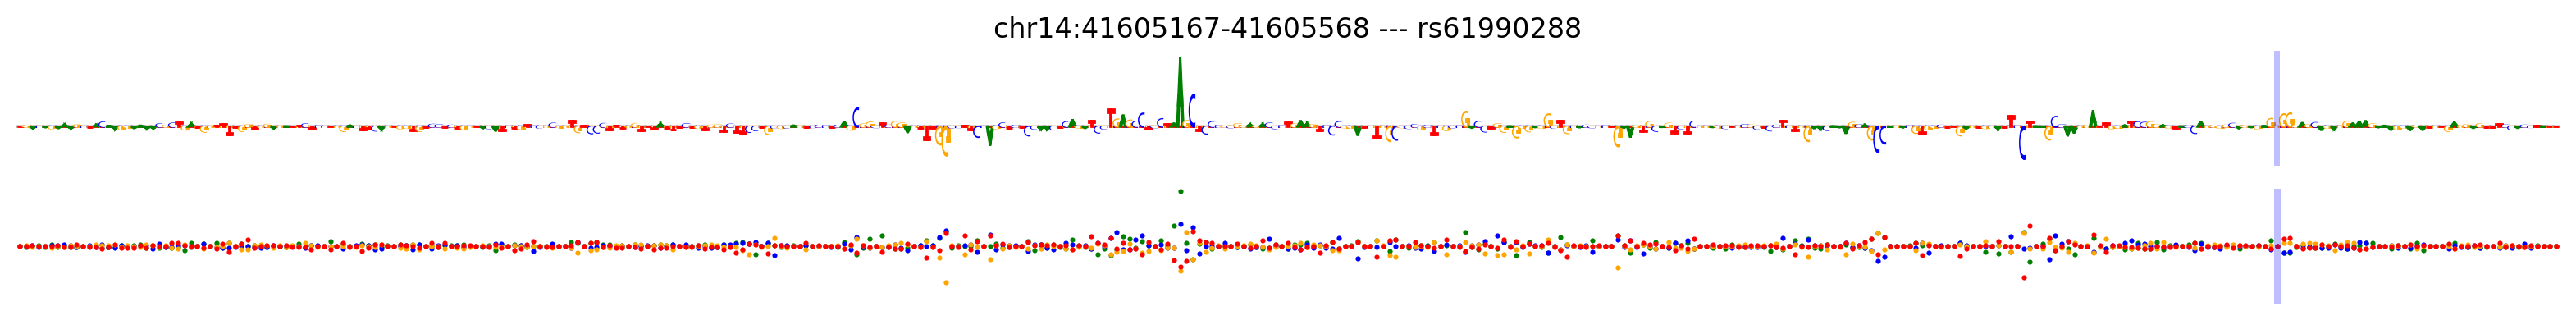

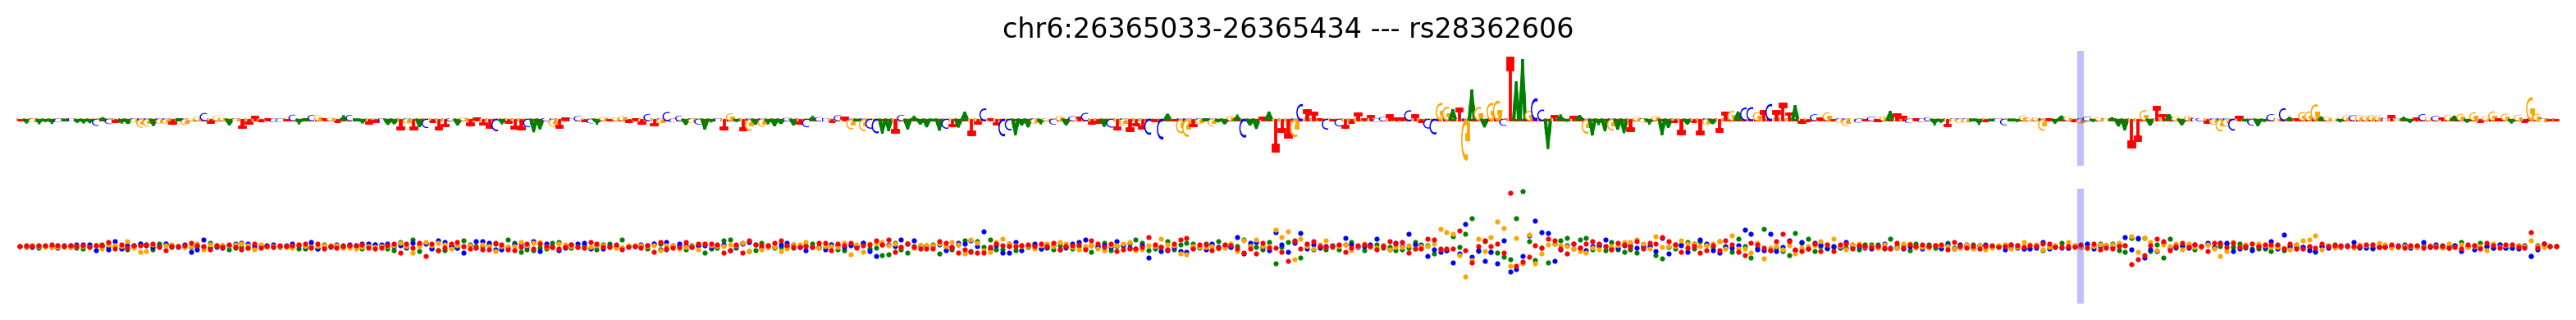

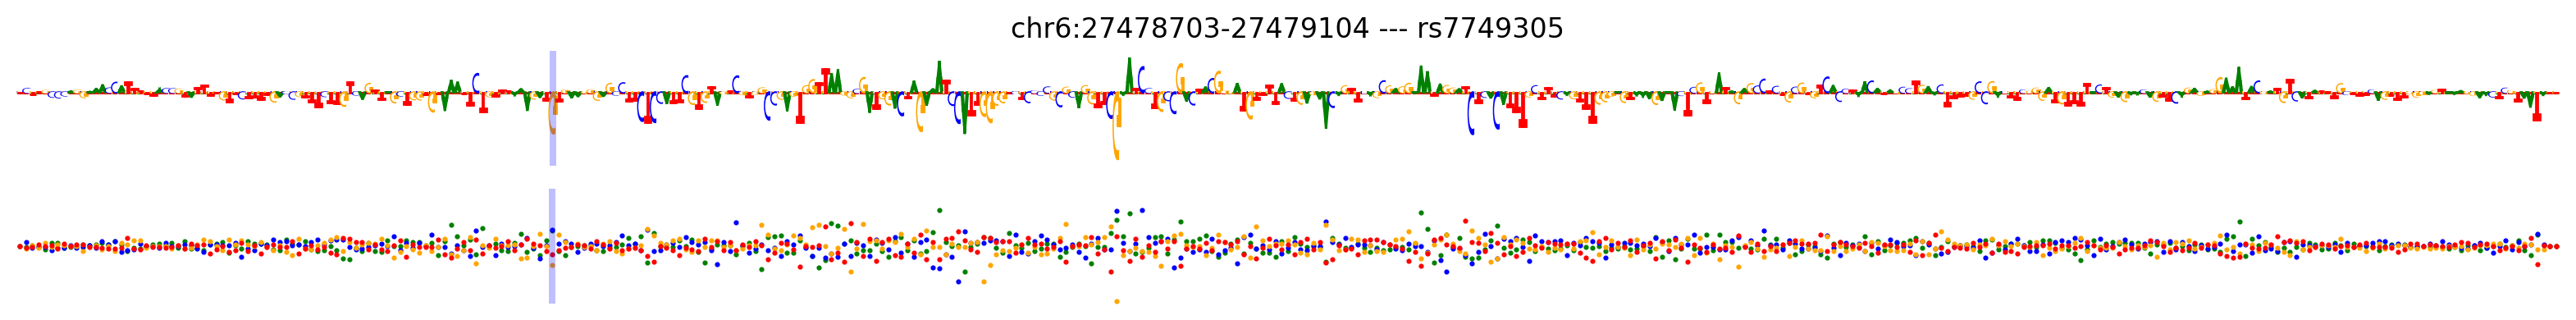

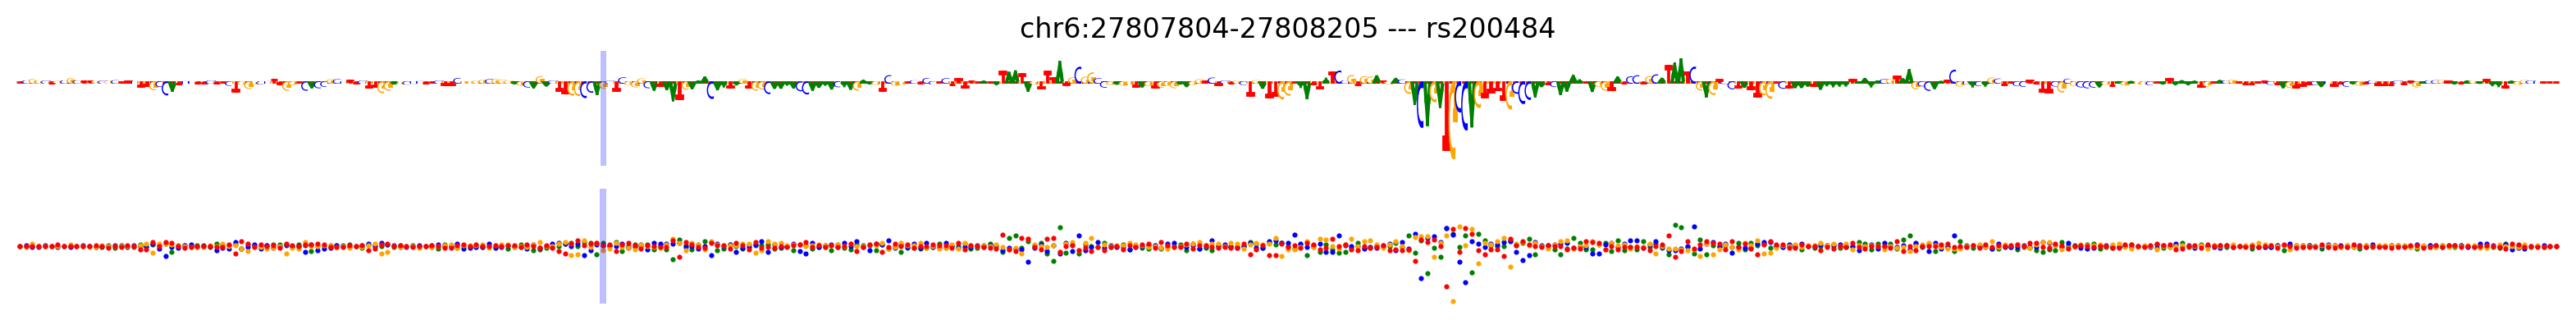

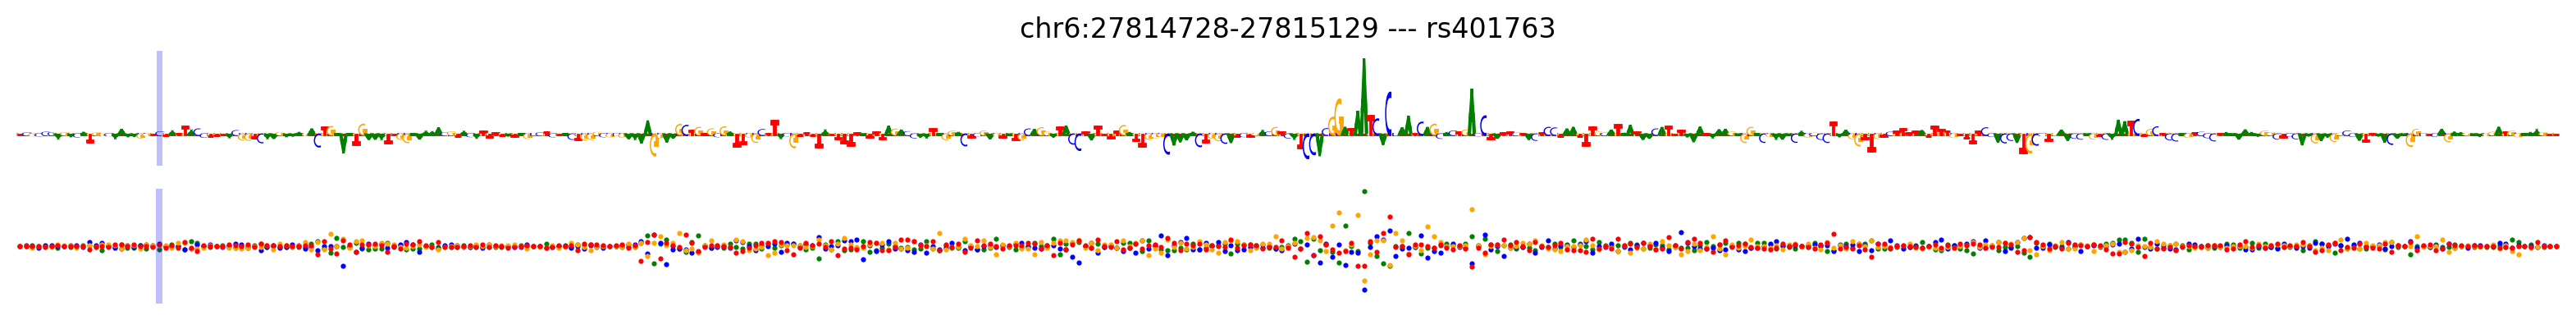

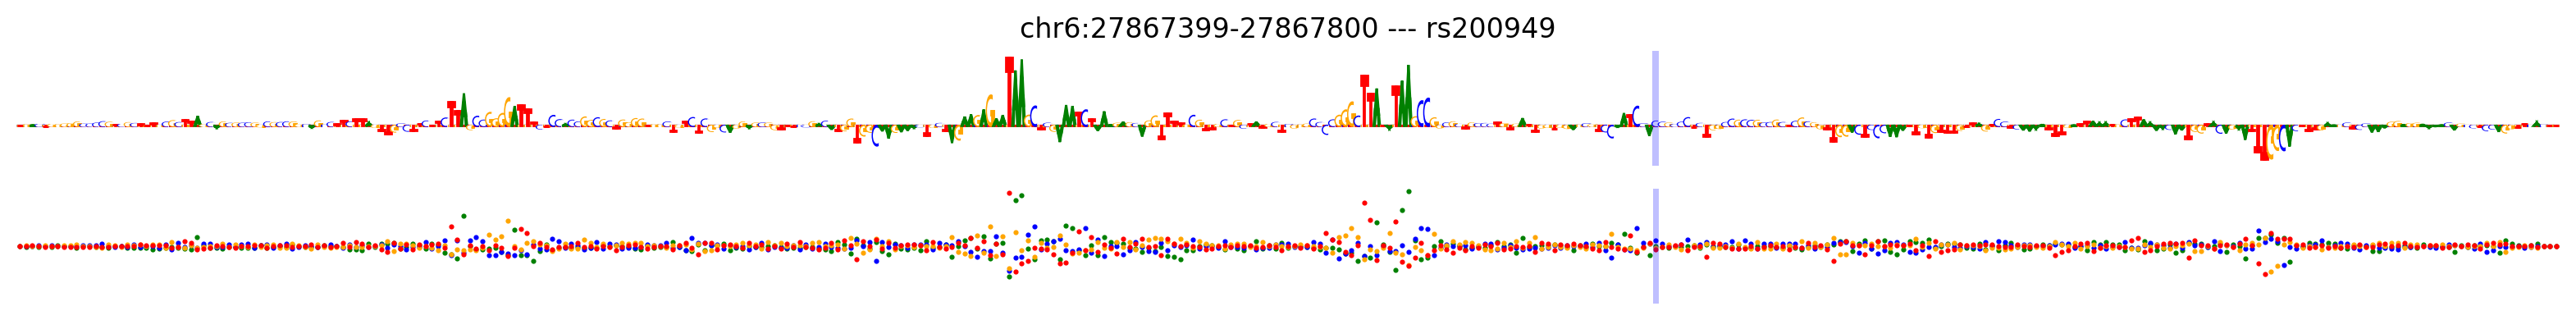

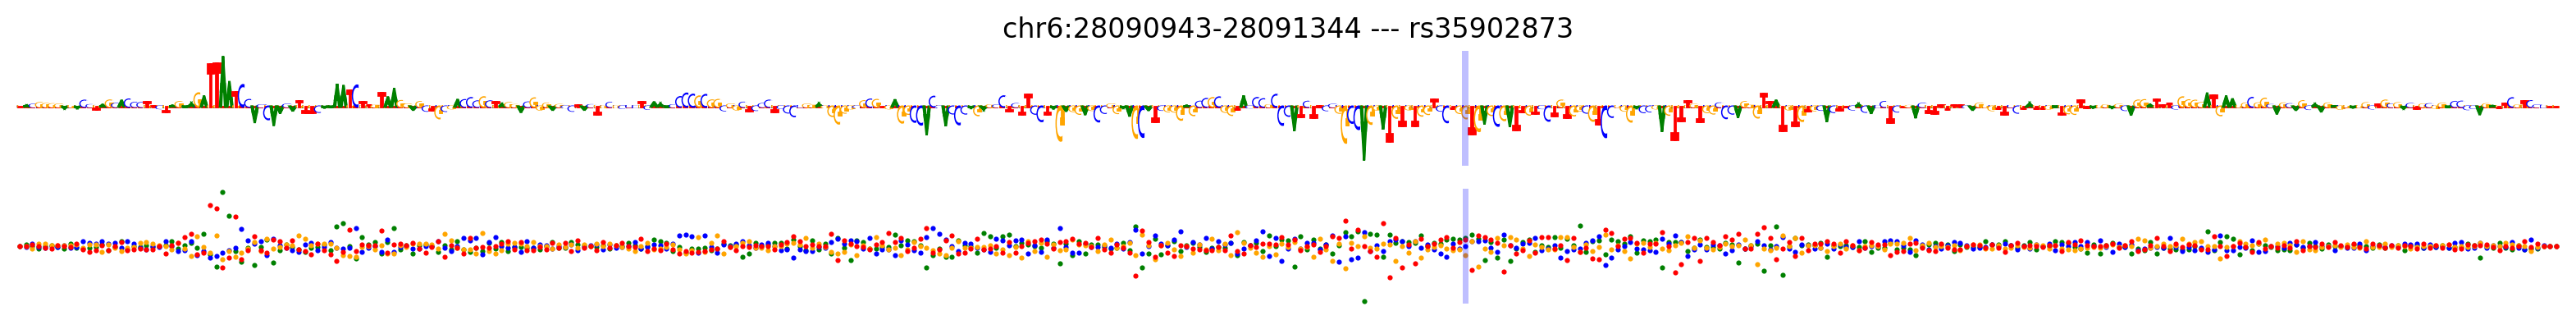

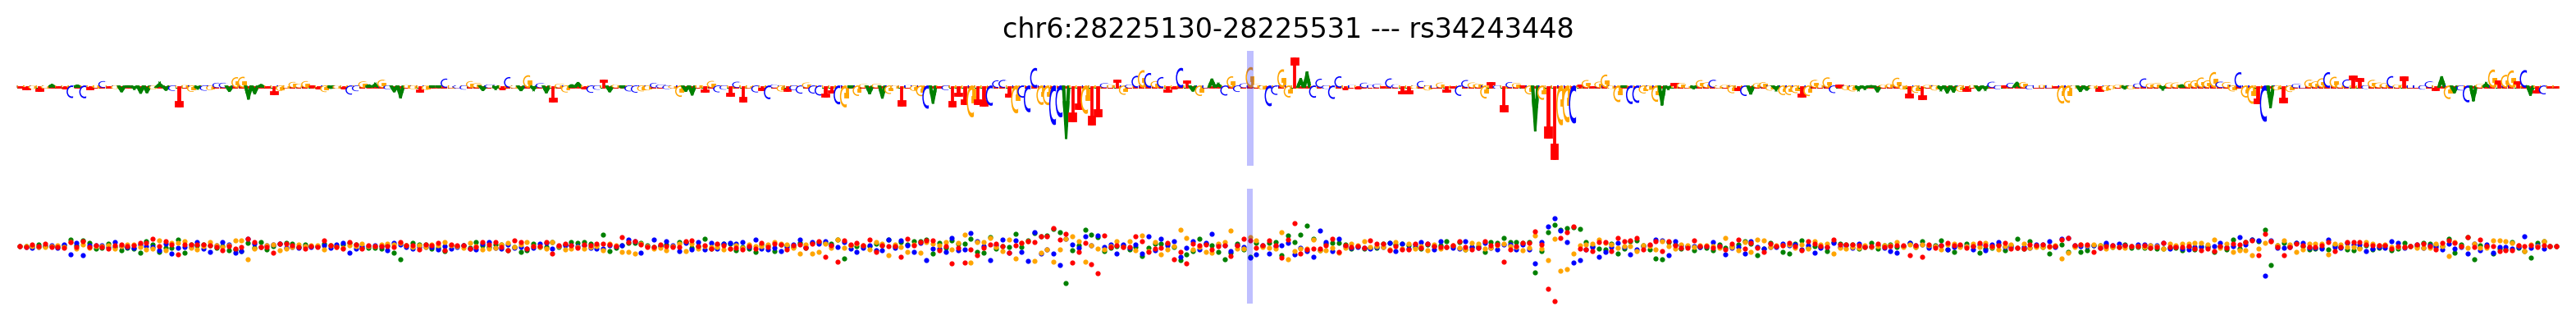

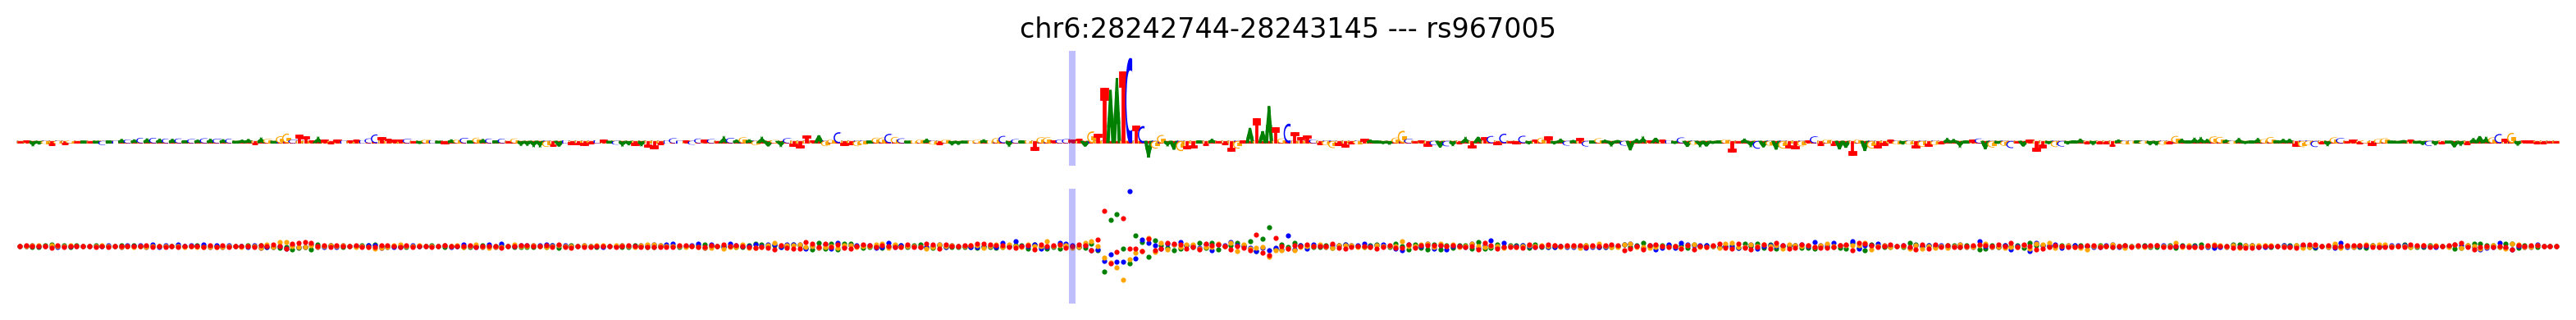

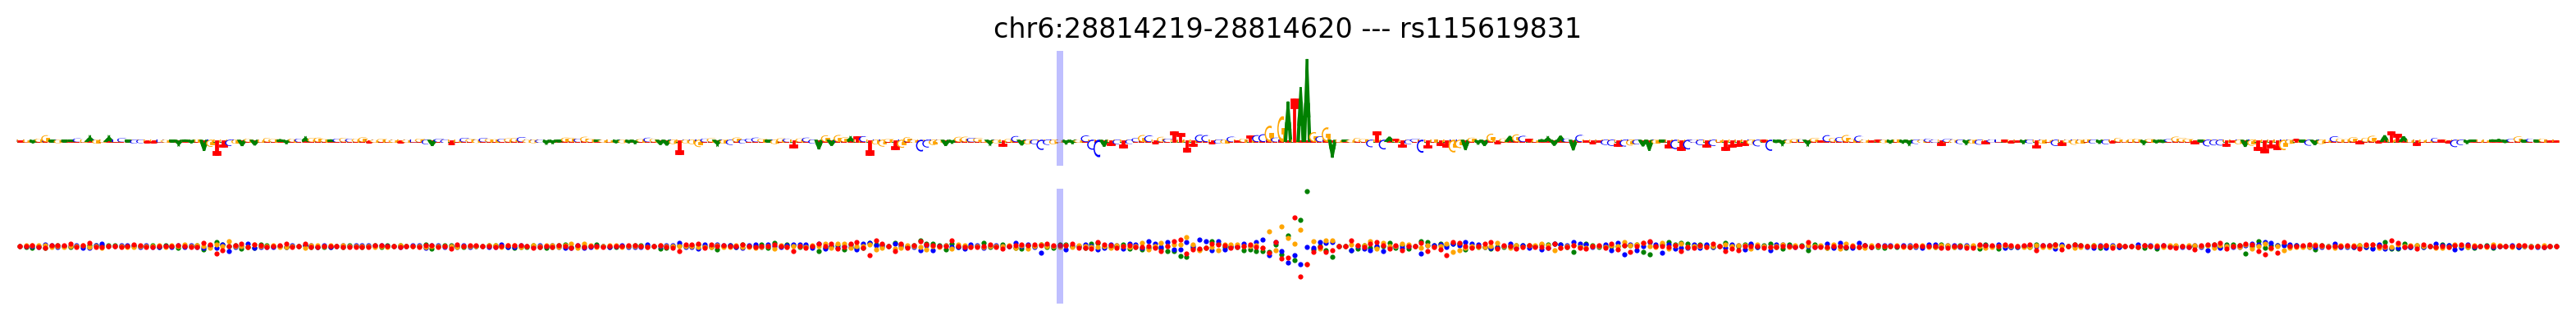

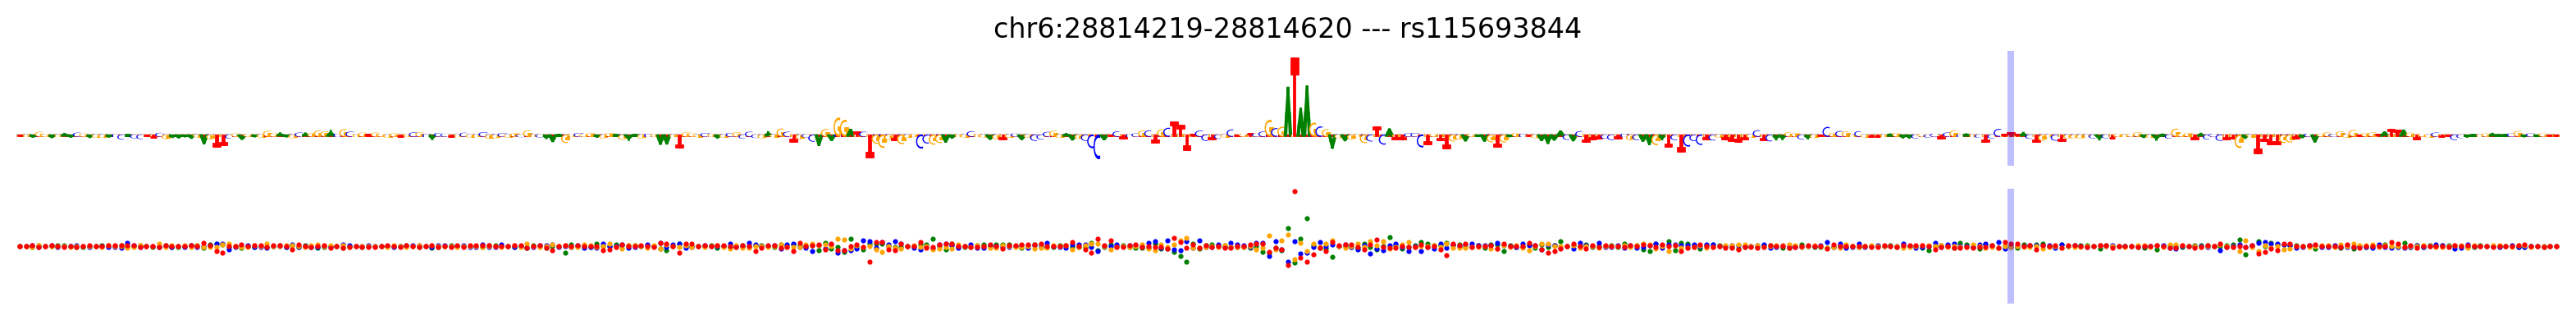

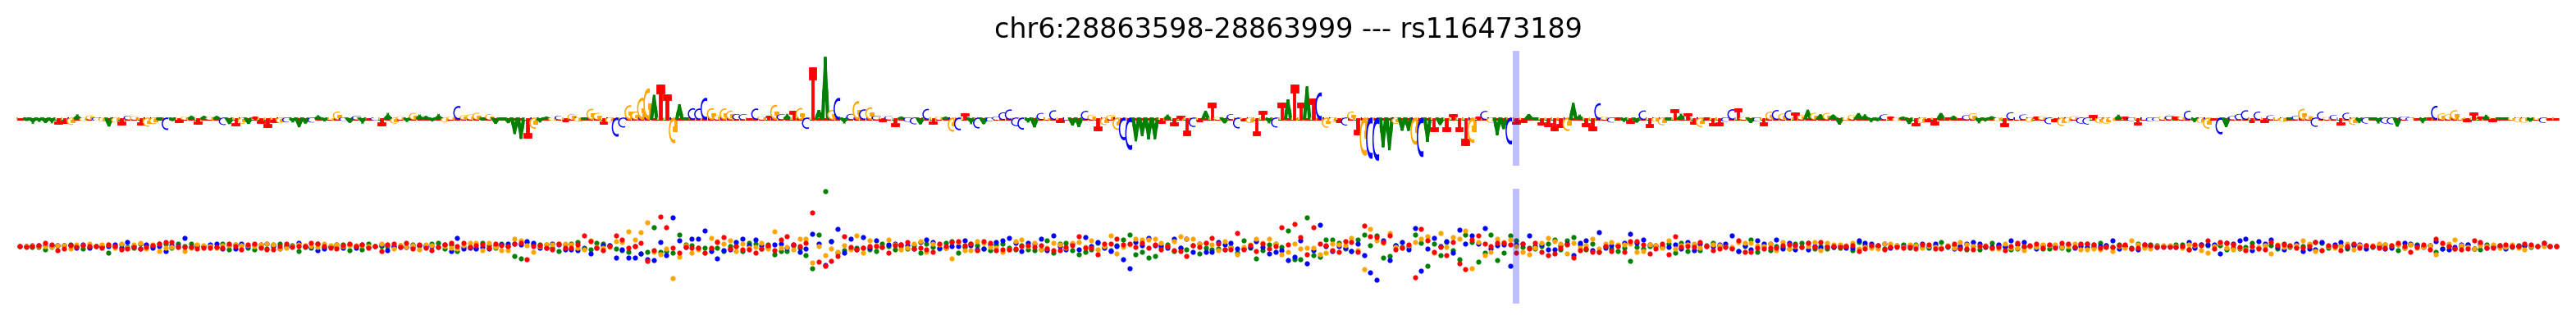

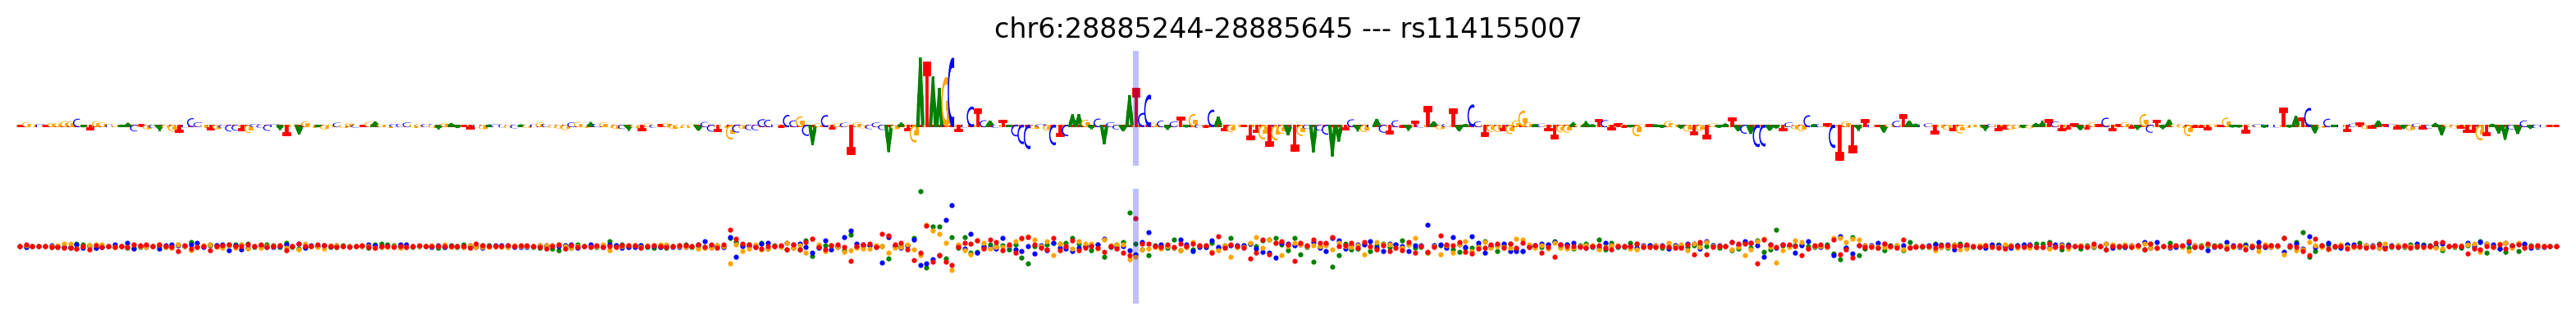

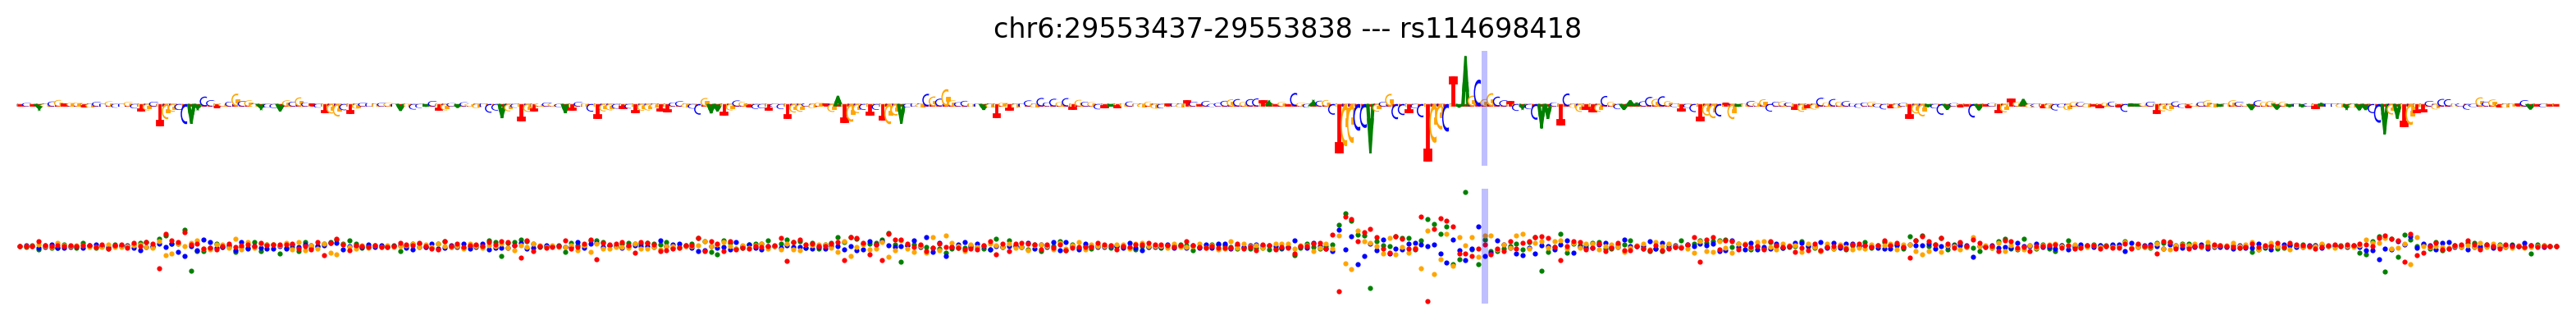

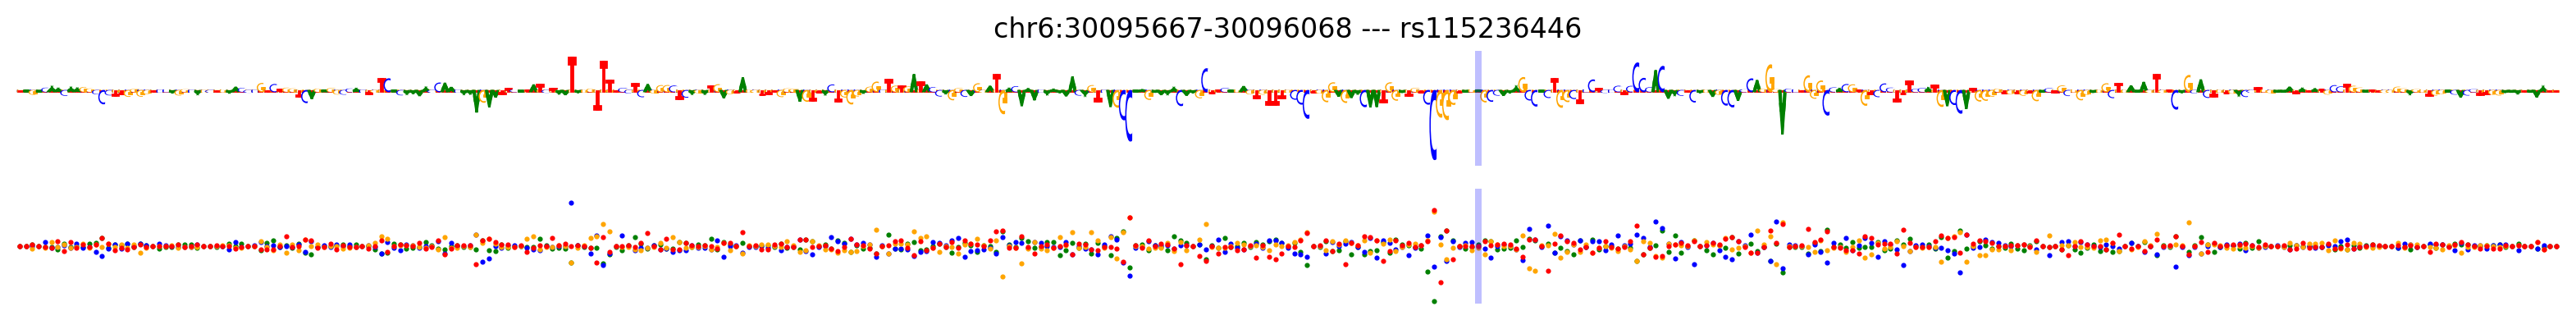

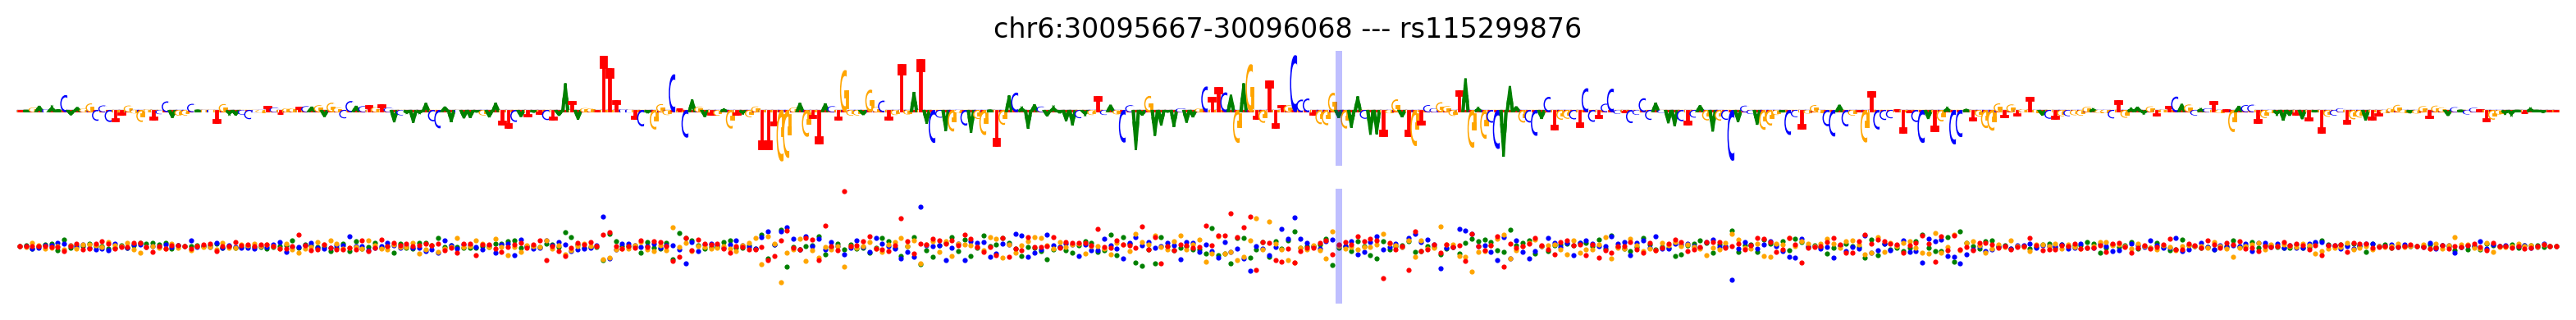

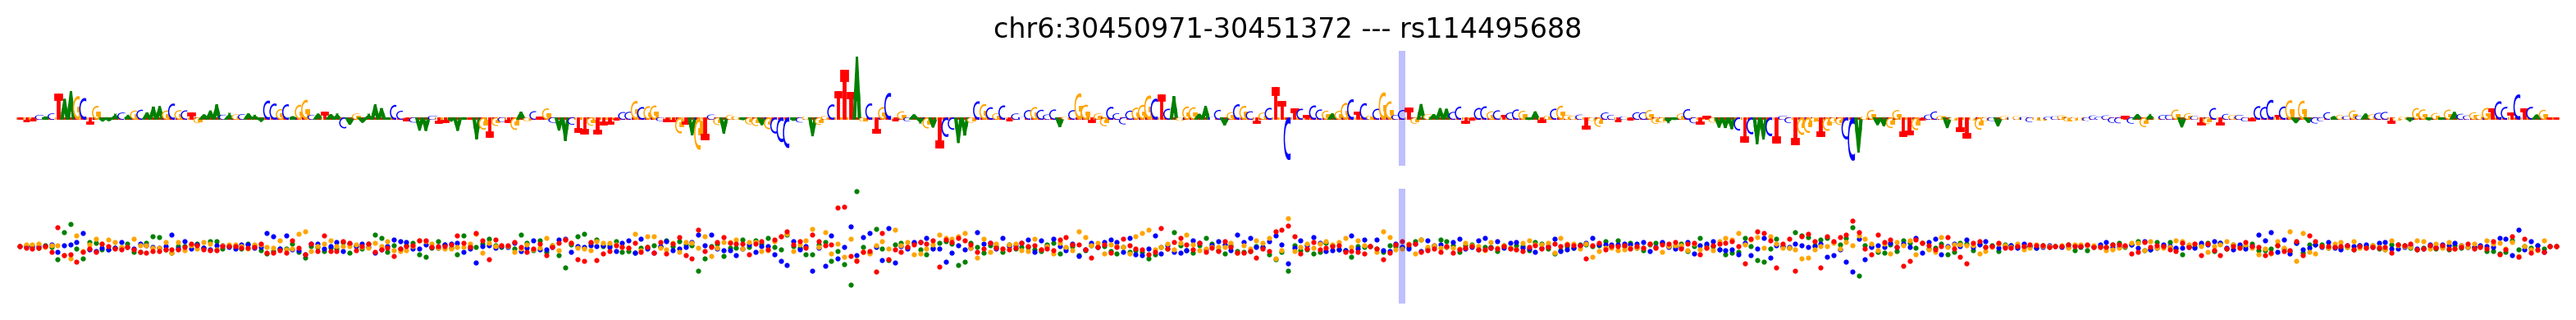

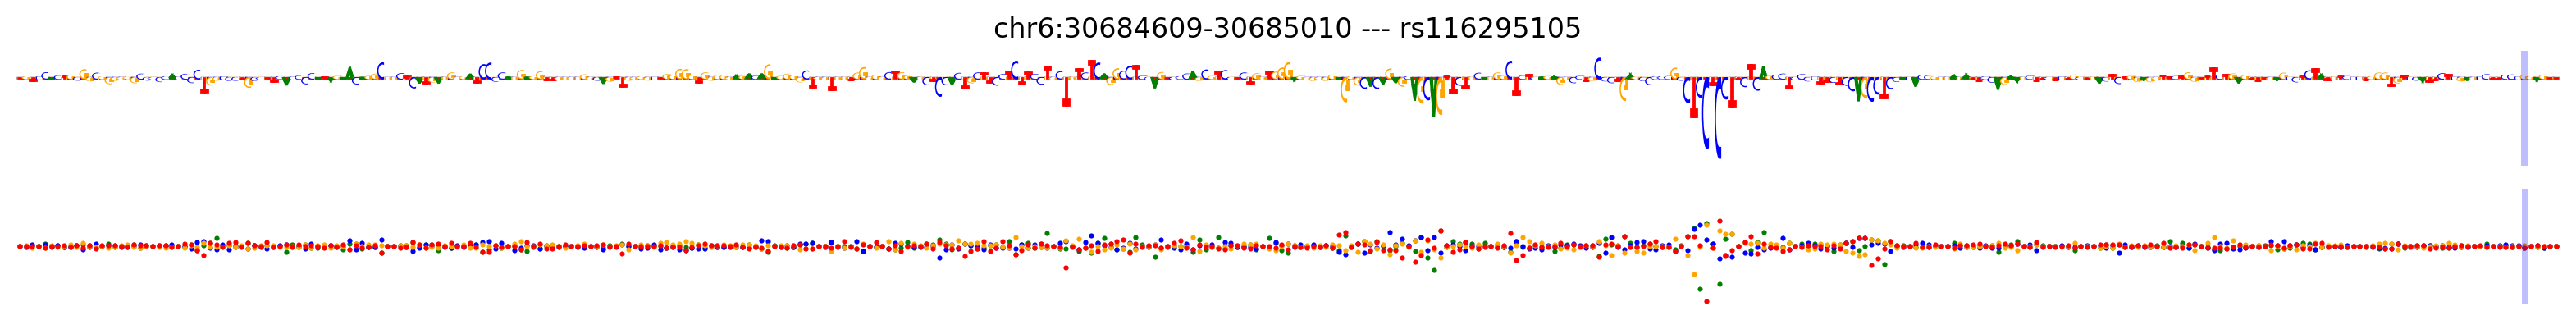

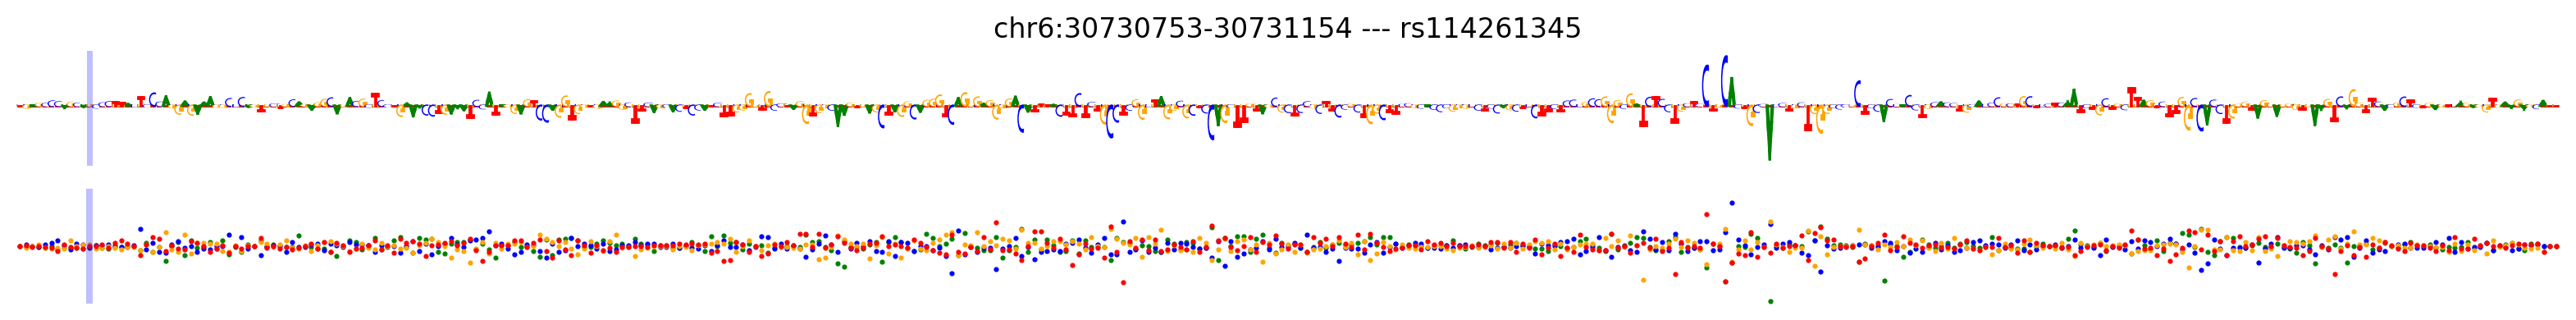

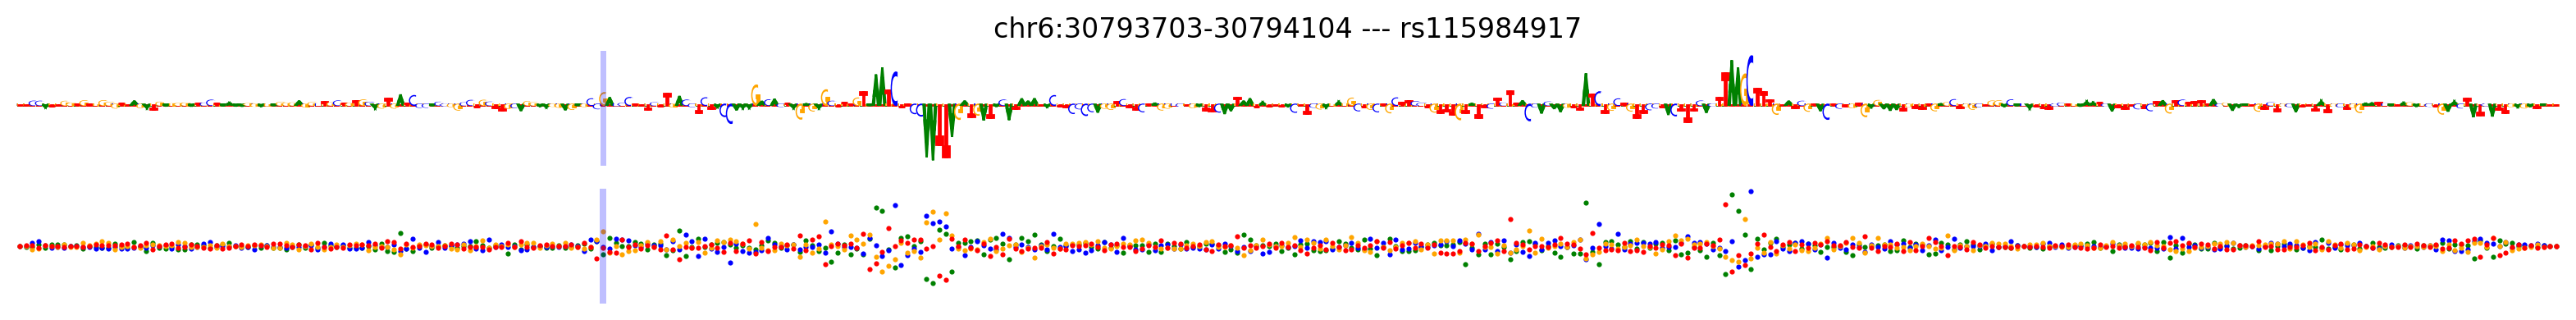

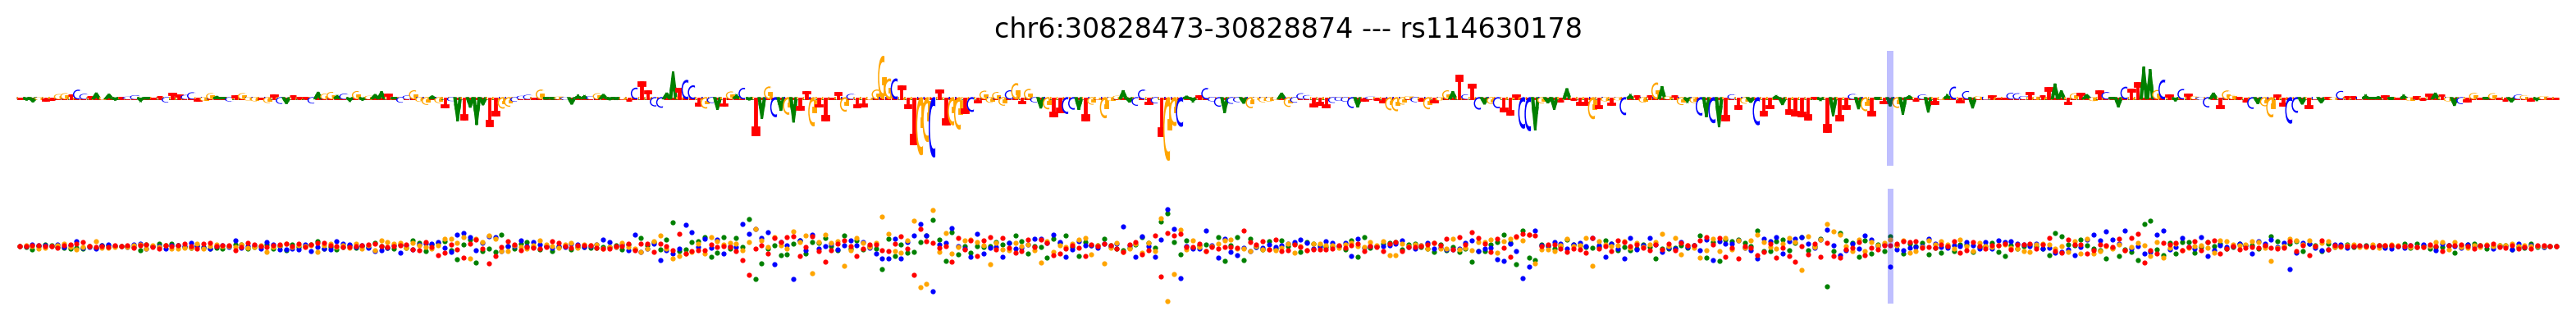

In [33]:
colors = ['Green', 'Blue', 'Orange', 'Red']

# valid = np.ones(len(valid_peaks))
for i, interval in enumerate(valid_peaks):
    if valid[i]:
        start = int(interval[1])
        SNP_pos = int(interval[7])
        offset = SNP_pos - start

        fig, ax = plt.subplots(2,1, figsize=(20,2))
        viz_sequence.plot_weights_given_ax(ax[0], contrib_scores[i], .1, .1, highlight = [], subticks_frequency=400)
        ax[0].axvspan(offset, offset+1, color='blue', alpha=0.25, lw=0)

        ax[0].set_title(enhancers[i] + ' --- ' + interval[9])
        ax[0].axis('off')

        hypo = hypo_contributions[i].T
        X = np.arange(hypo.shape[0])
        for x in range(4):
            ax[1].scatter(X, hypo[:,x], c=colors[x], lw=0, s=5)
        ax[1].axis('off')
        ax[1].axvspan(offset-.5, offset+.5, color='blue', alpha=0.25, lw=0)
        mx = np.max(abs(hypo))
        ax[1].set_ylim((-1.05*mx,1.05*mx))
        ax[1].set_xlim(-.5,400.5)

0.30936047 -0.14961904


<Figure size 640x480 with 0 Axes>

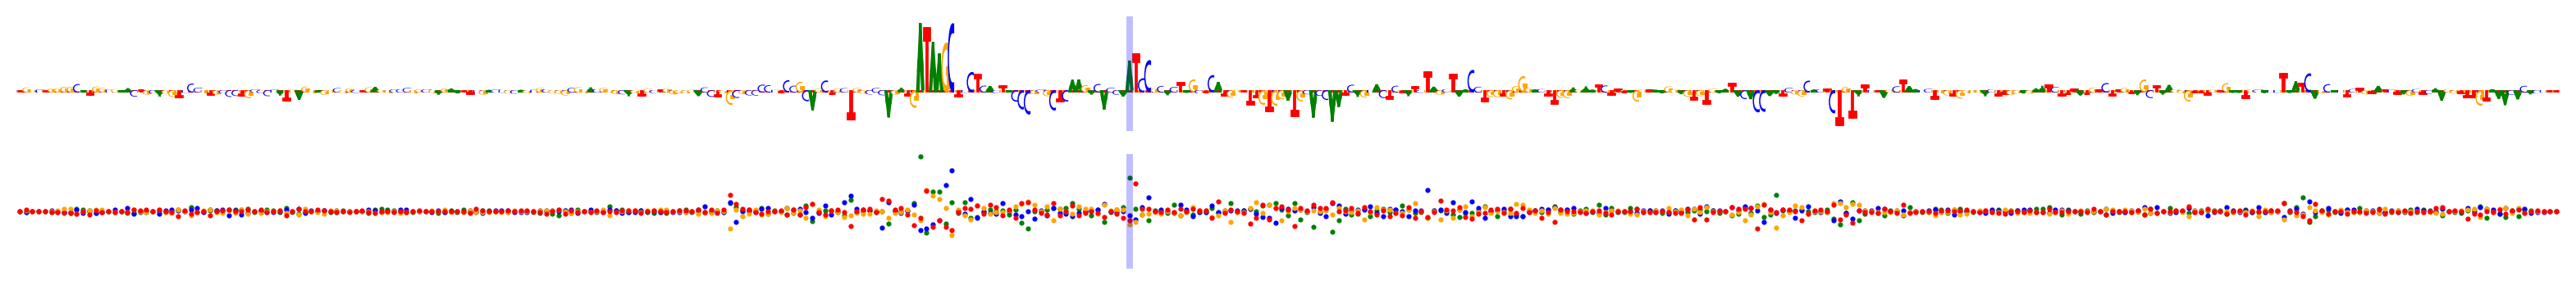

In [46]:
colors = ['Green', 'Blue', 'Orange', 'Red']

plot = 'chr6:28885244-28885645'

# valid = np.ones(len(valid_peaks))
for i, interval in enumerate(valid_peaks):
    if interval[3] == plot:
        start = int(interval[1])
        SNP_pos = int(interval[7])
        offset = SNP_pos - start

        fig, ax = plt.subplots(2,1, figsize=(20,2))
        viz_sequence.plot_weights_given_ax(ax[0], contrib_scores[i], .1, .1, highlight = [], subticks_frequency=400)
        ax[0].axvspan(offset-1, offset, color='blue', alpha=0.25, lw=0)

#         ax[0].set_title(enhancers[i] + ' --- ' + interval[9])
        ax[0].axis('off')
        print(np.max(contrib_scores[i]), np.min(contrib_scores[i]))

        hypo = hypo_contributions[i].T
        X = np.arange(hypo.shape[0])
        for x in range(4):
            ax[1].scatter(X, hypo[:,x], c=colors[x], lw=0, s=5)
        ax[1].axis('off')
        ax[1].axvspan(offset-1.5, offset-.5, color='blue', alpha=0.25, lw=0)
        mx = np.max(abs(hypo))
        ax[1].set_ylim((-1.05*mx,1.05*mx))
        ax[1].set_xlim(-.5,400.5)
        
    plt.savefig('/datb/sl/camiel/scATAC/DEV_manuscript/fig_5/fig5_OTX2_chr6:28885244-28885645_rs114155007.png', bbox_inches='tight', dpi=600)

In [43]:
enhancers[i]

'chr6:30828473-30828874'

In [22]:
f_bit = '/datb/sl/camiel/tumor/Enhancer_training/files/hg38.2bit'
cfname = "/proj/DEV_ATAC/ML_dev/20230125_submission/lightning_logs/CNN_deepGBM/version_0/checkpoints/epoch=26-step=3375.ckpt"

## Enhancers to annotate

regions = [f"{x[0]}:{x[1]}-{x[2]}" for x in SNPs_extended]
sequences = one_hot_encoder(regions, 401, f_bit)

hypo_contributions = []
contrib_scores= []
norm_scores = []

model = deepGBM.ConvolutionalClassificationModel.load_from_checkpoint(cfname, map_location=torch.device('cpu'))
model.eval()
explainer = DeepLiftShap(model)

labels = np.repeat(3, len(sequences))
for i in trange(len(sequences)):
    onehot_data = sequences[i]
    mult = explainer.attribute(torch.tensor(onehot_data[None, :, :]), shuffle_several_times(onehot_data), target=int(labels[i])).detach().numpy()[0]
    bg_data = np.mean(shuffle_several_times(onehot_data).numpy(),axis=0)

    hypo = combine_mult_and_diffref(mult, orig_inp=torch.tensor(onehot_data[None, :, :]), bg_data=bg_data)
    hypo_contributions.append(hypo)
    
    dinuc_shuff_explanation = np.sum(mult, axis=0) * onehot_data
    norm = dinuc_shuff_explanation - np.mean(dinuc_shuff_explanation,axis=0)[np.newaxis,:]
    contrib_scores.append(dinuc_shuff_explanation)
    norm_scores.append(norm)

847it [00:00, 2378.42it/s]
  0%|          | 0/847 [00:00<?, ?it/s]Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
An invalid module MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) is detected. Saved gradients will
                be used as the gradients of the module's input tensor.
                See MaxPool1d as an example.
100%|██████████| 847/847 [24:01<00:00,  1.70s/it]


78

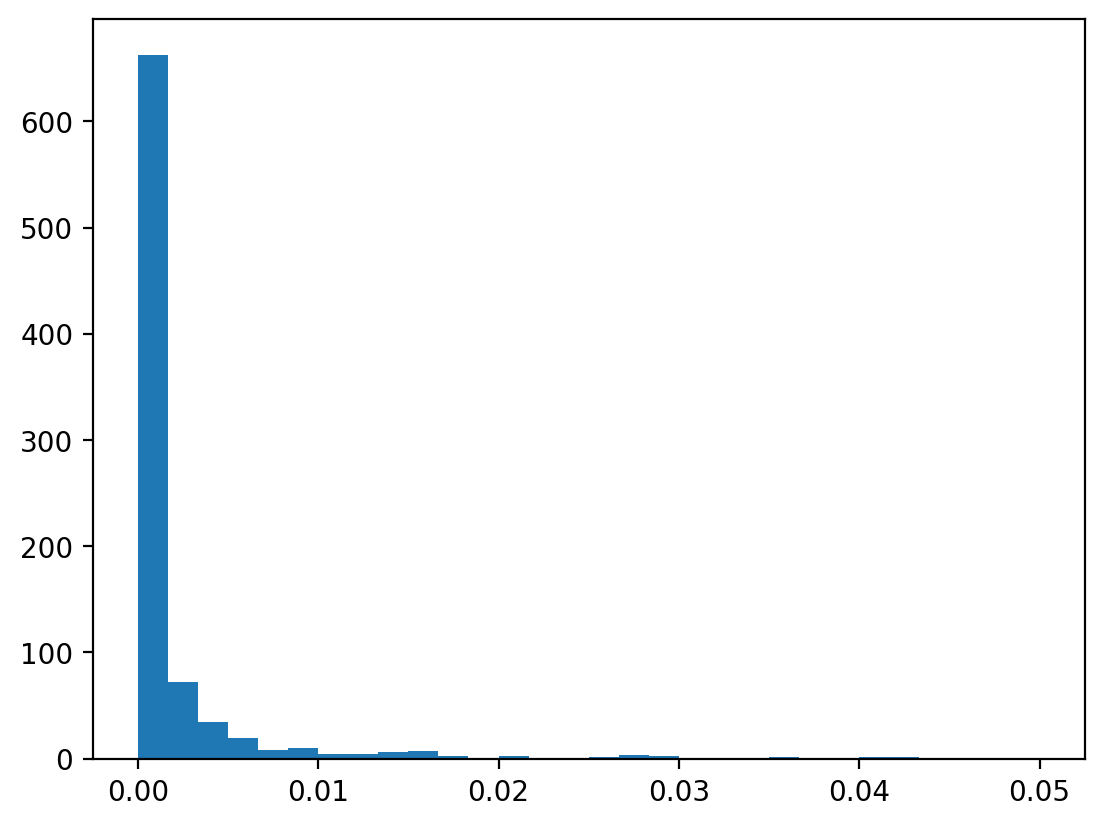

In [31]:
v = []
for i, interval in enumerate(SNPs_extended):
    v.append(np.max(norm_scores[i][:,200]))
v = np.array(v)
plt.hist(v, bins=30, range=(0,.05))

np.sum(v>.005)

## Hit scoring

In [12]:
import sys, os

import numpy as np
import torch
import logging

import pandas as pd

import pickle as pkl
import logging
import h5py
import numpy as np
from importlib import reload
import modisco
reload(modisco.util)
reload(modisco.core)
reload(modisco.tfmodisco_workflow)
from modisco.tfmodisco_workflow import workflow

import modisco
import modisco.util
reload(modisco.util)
reload(modisco.cluster.core)
reload(modisco.coordproducers)
from modisco.visualization import viz_sequence
reload(modisco.aggregator)
from modisco import hit_scoring
reload(modisco.hit_scoring)
from modisco.hit_scoring import densityadapted_hitscoring
reload(modisco.hit_scoring.densityadapted_hitscoring)
reload(densityadapted_hitscoring)
reload(modisco.cluster.core)

<module 'modisco.cluster.core' from '/home/camiel/git_repos/tfmodisco/modisco/cluster/core.py'>

In [14]:
enh = pd.read_csv('/proj/DEV_ATAC/submission/GWAS_analysis/sig_peaks_DEP_multiple_test.csv')
enhancers = enh['GENE']

In [15]:
f_bit = '/datb/sl/camiel/tumor/Enhancer_training/files/hg38.2bit'
cfname = "/proj/DEV_ATAC/ML_dev/20230125_submission/lightning_logs/CNN_deepGBM/version_0/checkpoints/epoch=26-step=3375.ckpt"

## Enhancers to annotate
sequences = one_hot_encoder(enhancers, 401, f_bit)

hypo_contributions = []
contrib_scores= []
norm_scores = []

model = deepGBM.ConvolutionalClassificationModel.load_from_checkpoint(cfname, map_location=torch.device('cpu'))
model.eval()
explainer = DeepLiftShap(model)

labels = np.repeat(3, len(sequences))
for i in trange(len(sequences)):
    onehot_data = sequences[i]
    mult = explainer.attribute(torch.tensor(onehot_data[None, :, :]), shuffle_several_times(onehot_data), target=int(labels[i])).detach().numpy()[0]
    bg_data = np.mean(shuffle_several_times(onehot_data).numpy(),axis=0)

    hypo = combine_mult_and_diffref(mult, orig_inp=torch.tensor(onehot_data[None, :, :]), bg_data=bg_data)
    hypo_contributions.append(hypo)
    
    dinuc_shuff_explanation = np.sum(mult, axis=0) * onehot_data
    norm = dinuc_shuff_explanation - np.mean(dinuc_shuff_explanation,axis=0)[np.newaxis,:]
    contrib_scores.append(dinuc_shuff_explanation)
    norm_scores.append(norm)
    
contrib_scores = np.array([x.T for x in contrib_scores])
hypo_contributions = np.array([x.T for x in hypo_contributions])

sequences = one_hot_encoder(enhancers, 401, f_bit)
sequences = np.array([x.T for x in sequences

114it [00:01, 103.69it/s]
  0%|          | 0/114 [00:00<?, ?it/s]Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
An invalid module MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) is detected. Saved gradients will
                be used as the gradients of the module's input tensor.
                See MaxPool1d as an example.
The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484806139/work/aten/src/ATen/native/TensorShape.cpp:2981.)
100%|██████████| 114/114 [03:21<00:00,  1.77s/it]


In [59]:
contrib_scores.shape

(114, 401, 4)

In [60]:
hit_scorer, _, _ = pkl.load(open(f'/proj/DEV_ATAC/ML_dev/20230125_submission/modisco_results/output/scoring_3.pkl', 'rb'))

# #set the method used to identify coordinates of high importance ("seqlets")
# #You have to provide a contribution score track as this will be used
# # to calibrate the threshold used for seqlet identification. You
# # can also optionally provide an empirical null distribution track via
# # the 'null_track' argument, similar to when tf-modisco is first run.
# hit_scorer.set_coordproducer(contrib_scores={'task0': np.array(contrib_scores)},
#                              core_sliding_window_size=7,
#                              target_fdr=0.2,
#                              min_passing_windows_frac=0.03,
#                              max_passing_windows_frac=0.2,
#                              separate_pos_neg_thresholds=False,                             
#                              max_seqlets_total=np.inf)

#Now that the hit-scorer is configured, you can call it on some data to
# get the motif hit calls.
#Note that the values provided to contrib_scores below DO NOT have to be
# the same as the values provided to set_coordproducer above.
#I recommend running this on a small number of regions first to get a feel
# for the runtime; we're still working on improving the runtime here.
(exampleidx_to_matches, patternidx_to_matches) = hit_scorer(
           contrib_scores={'task0': contrib_scores},
           hypothetical_contribs={'task0': hypo_contributions},
           one_hot=sequences,
           hits_to_return_per_seqlet=1)

Computing windowed sums on original
Only returning positive coords!
Got 179 coords
Launching nearest neighbors affmat calculation job
MEMORY 1.975607296
Parallel runs completed
MEMORY 1.975607296
Job completed in: 1.08 s
MEMORY 1.975607296
Launching nearest neighbors affmat calculation job
MEMORY 1.975607296
Parallel runs completed
MEMORY 1.975607296
Job completed in: 1.0 s
MEMORY 1.975607296
On seqlets 0 to 179 out of 179


100%|██████████| 76/76 [00:02<00:00, 27.51it/s]

Launching nearest neighbors affmat calculation job
MEMORY 1.975607296


Parallel runs completed
MEMORY 1.975607296
Job completed in: 0.66 s
MEMORY 1.975607296
Launching nearest neighbors affmat calculation job
MEMORY 1.975607296
Parallel runs completed
MEMORY 1.975607296
Job completed in: 0.66 s
MEMORY 1.975607296
On seqlets 0 to 179 out of 179


100%|██████████| 10/10 [00:00<00:00, 118.19it/s]


Removed 0 duplicates


In [84]:
print('OTX2: ', len(patternidx_to_matches[0]))
print('GATA: ', len(patternidx_to_matches[1]))

OTX2:  22
GATA:  36


Computing windowed sums on original
Only returning positive coords!
Got 2 coords
Original core seqlet locations


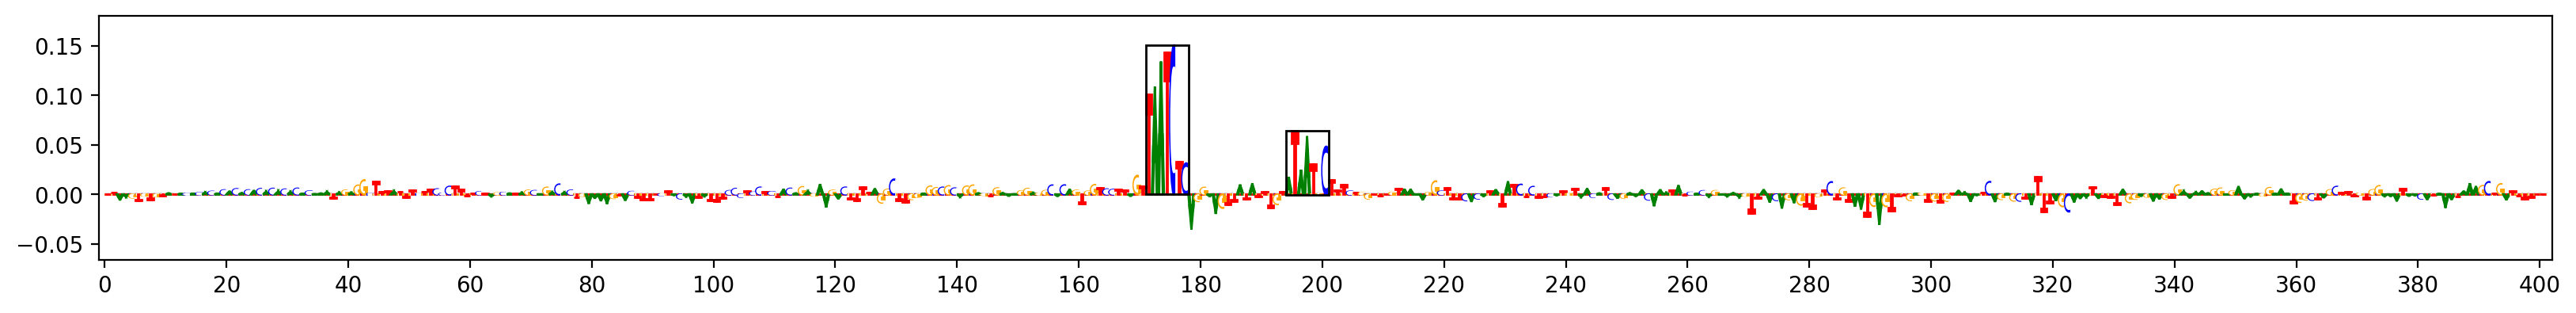

Computing windowed sums on original
Only returning positive coords!
Got 4 coords
Original core seqlet locations


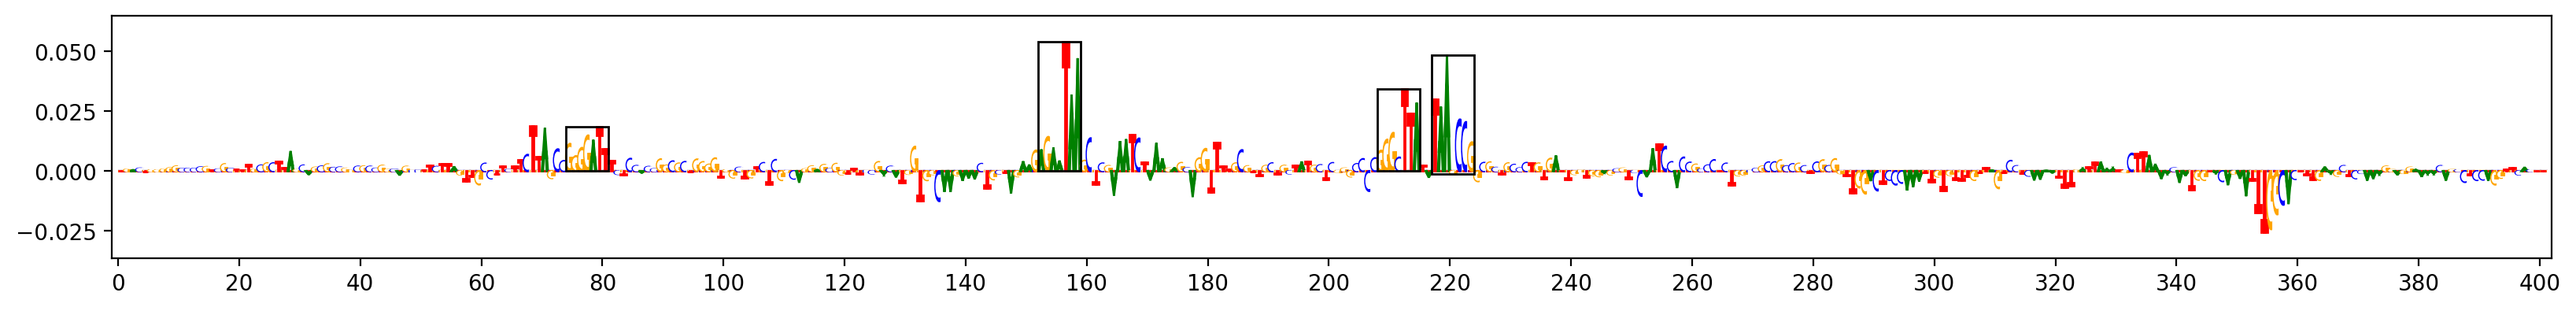

Computing windowed sums on original
Only returning positive coords!
Got 2 coords
Original core seqlet locations


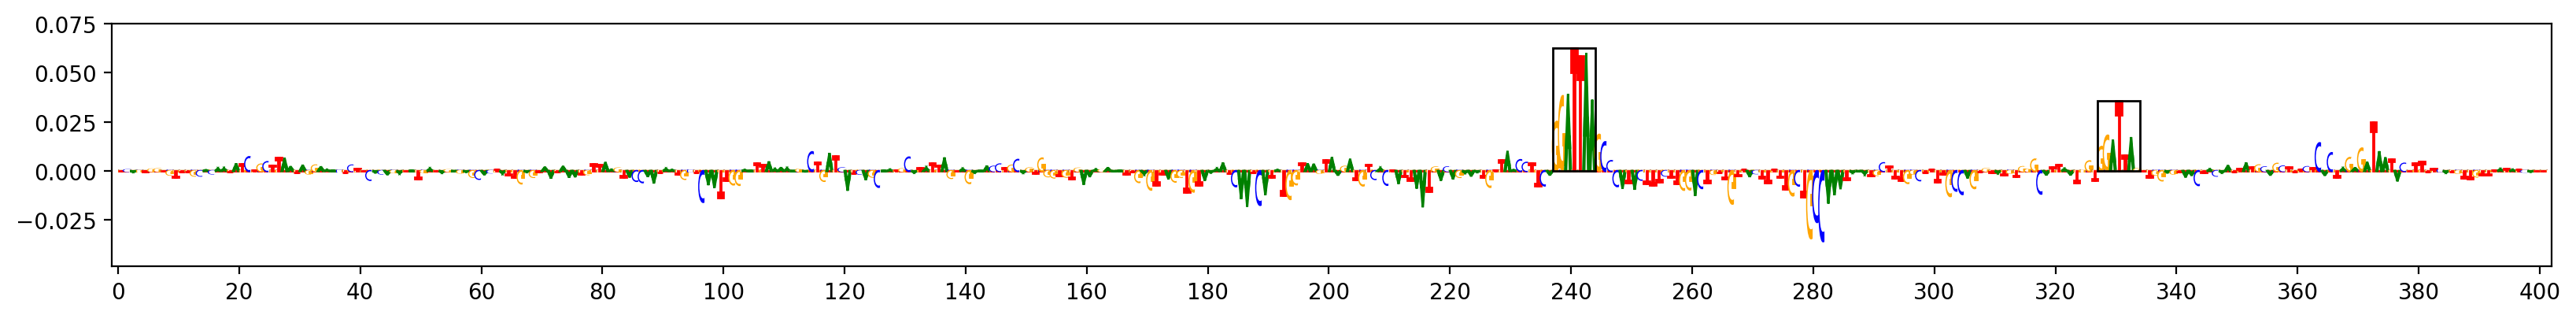

Computing windowed sums on original
Only returning positive coords!
Got 2 coords
Original core seqlet locations


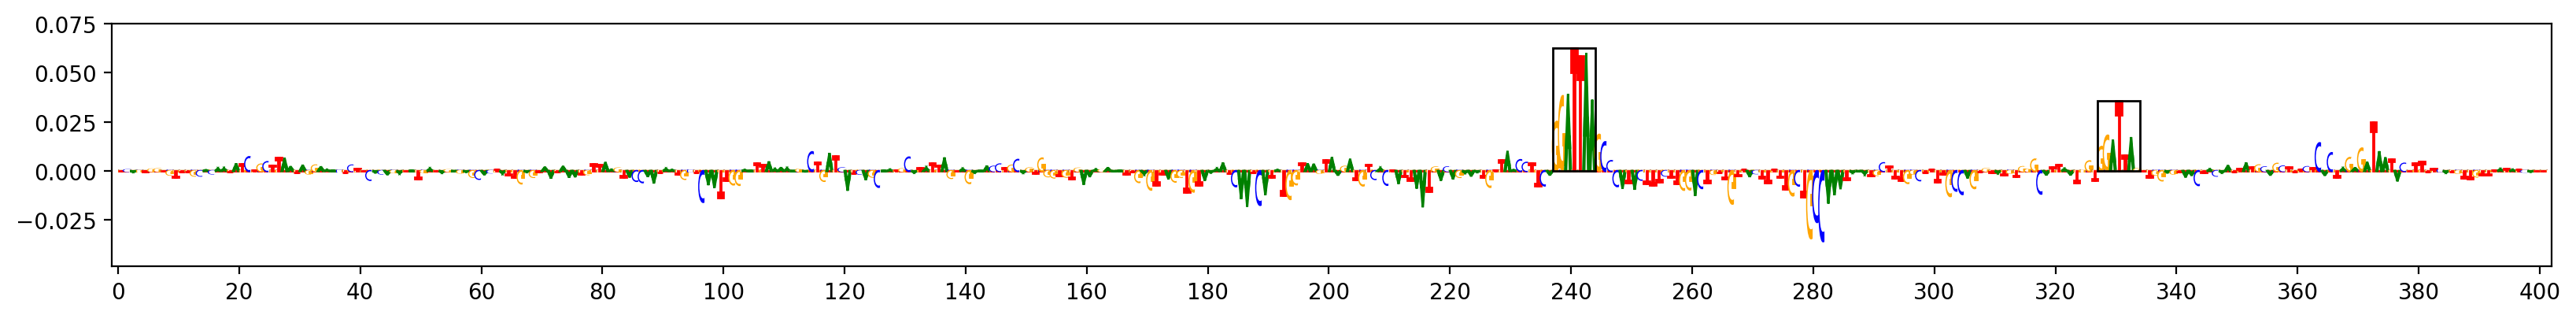

Computing windowed sums on original
Only returning positive coords!
Got 10 coords
Original core seqlet locations


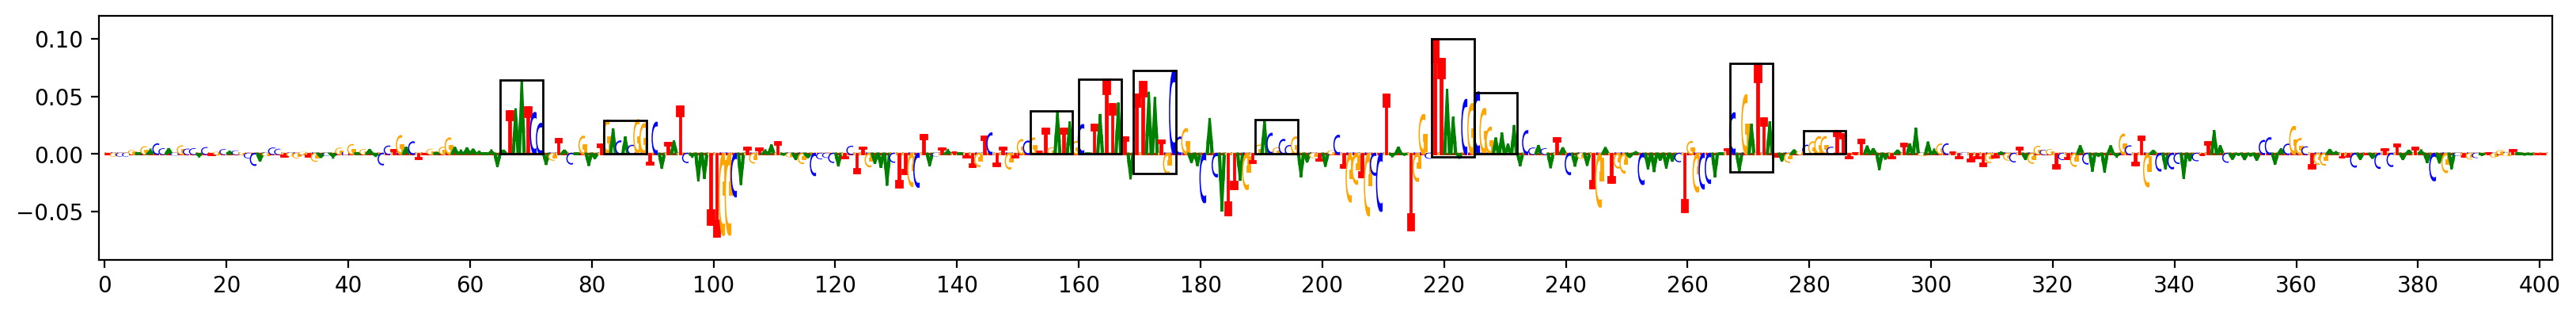

Computing windowed sums on original
Only returning positive coords!
Got 10 coords
Original core seqlet locations


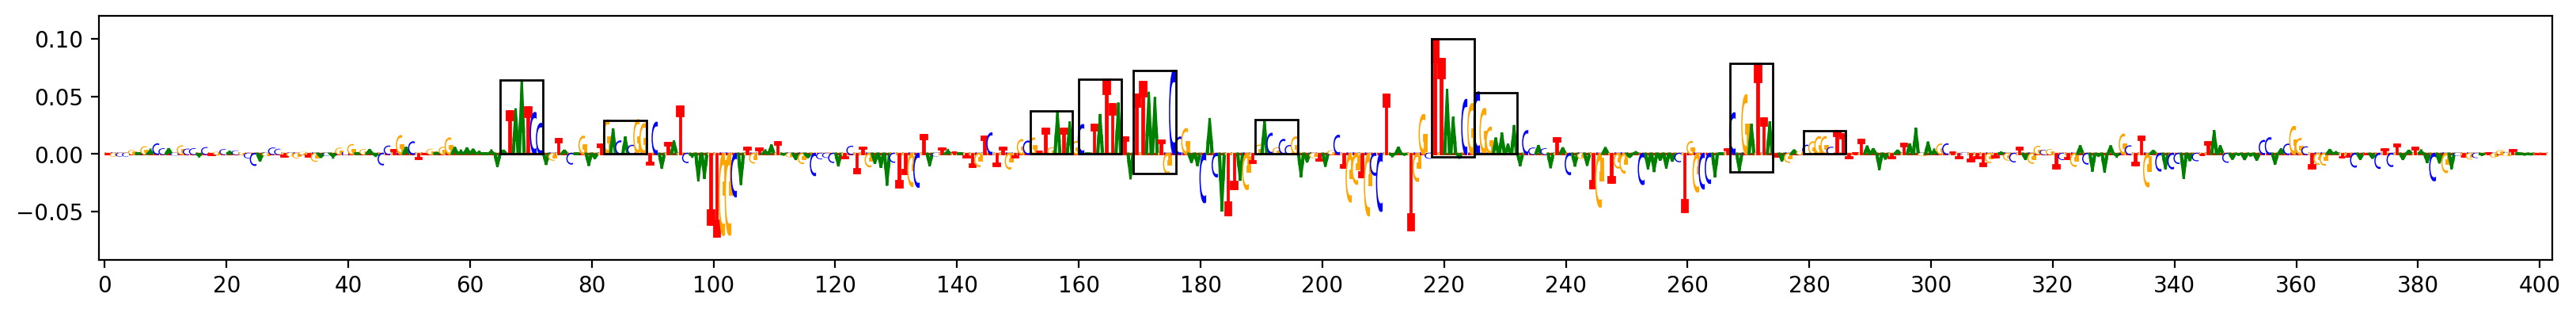

Computing windowed sums on original
Only returning positive coords!
Got 5 coords
Original core seqlet locations


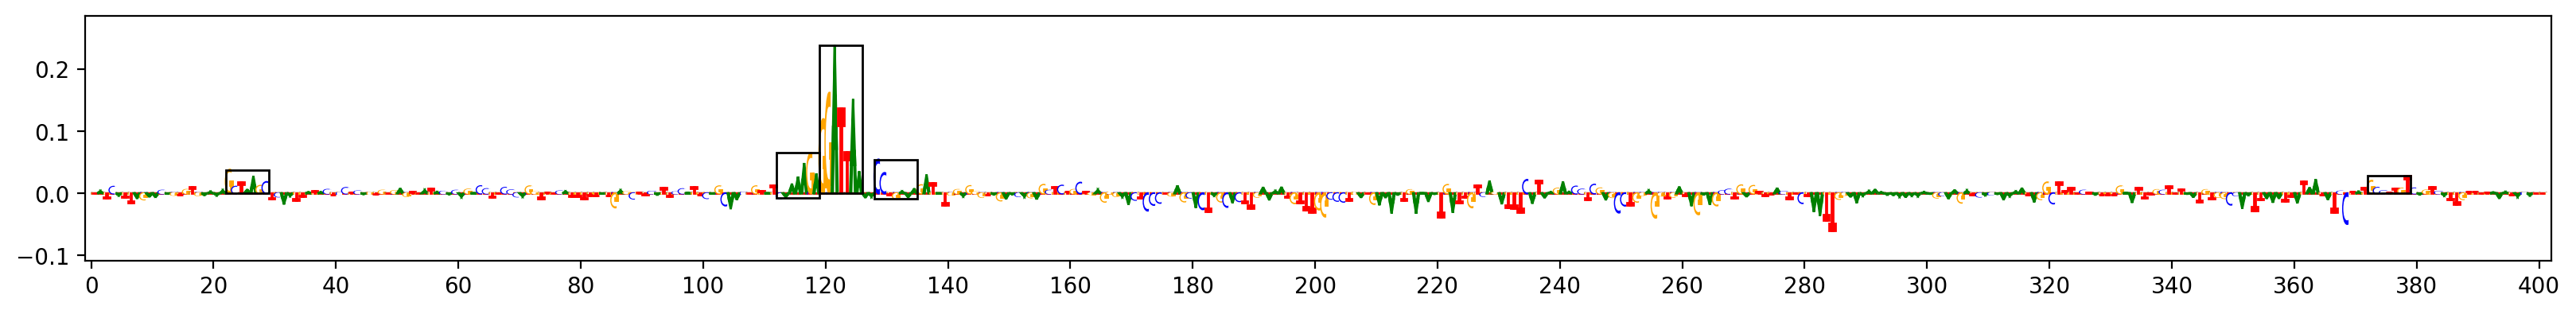

Computing windowed sums on original
Only returning positive coords!
Got 4 coords
Original core seqlet locations


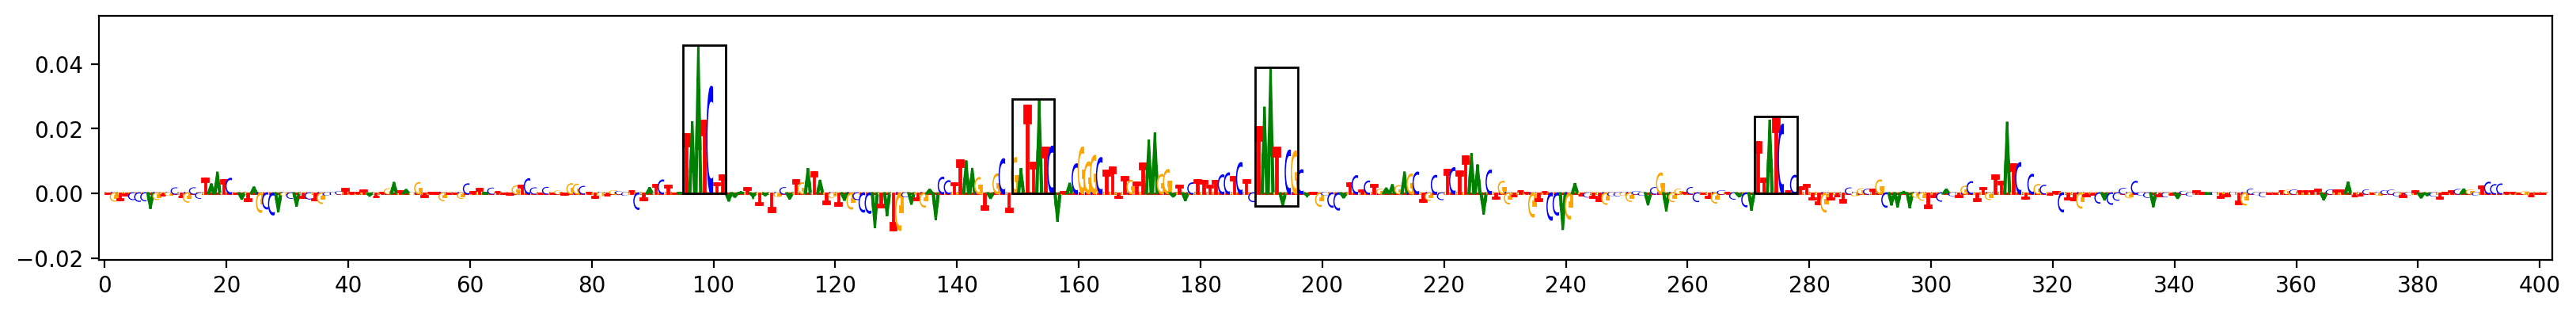

Computing windowed sums on original
Only returning positive coords!
Got 5 coords
Original core seqlet locations


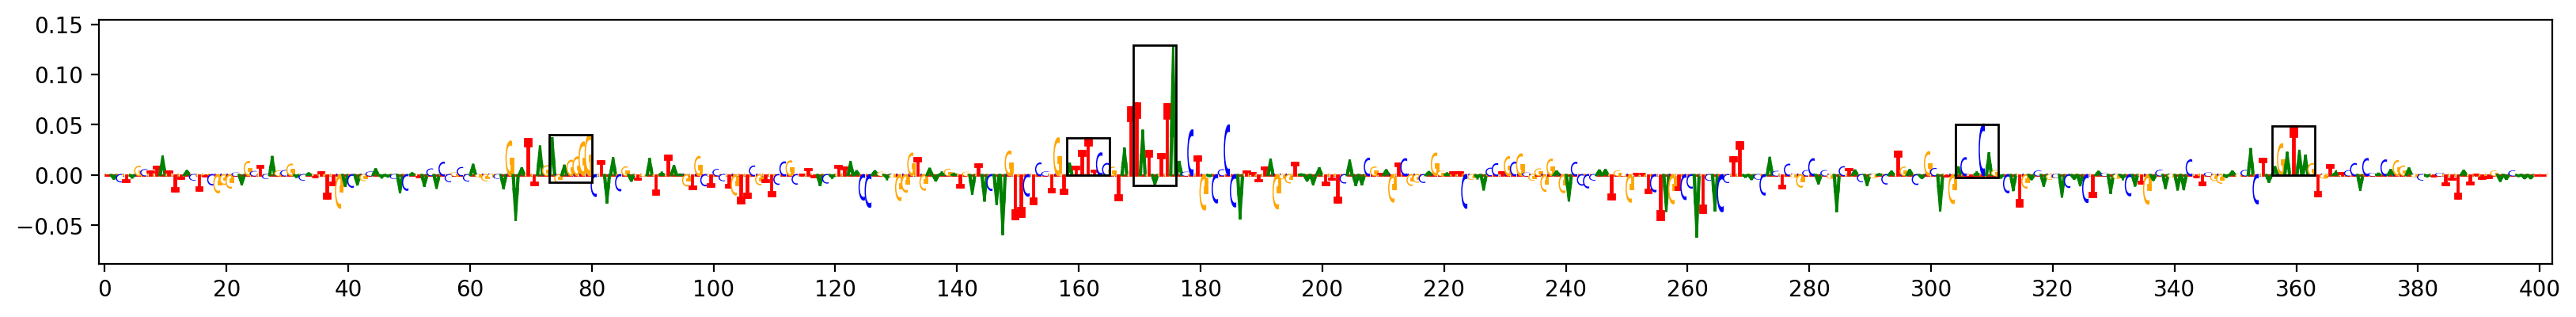

Computing windowed sums on original
Only returning positive coords!
Got 5 coords
Original core seqlet locations


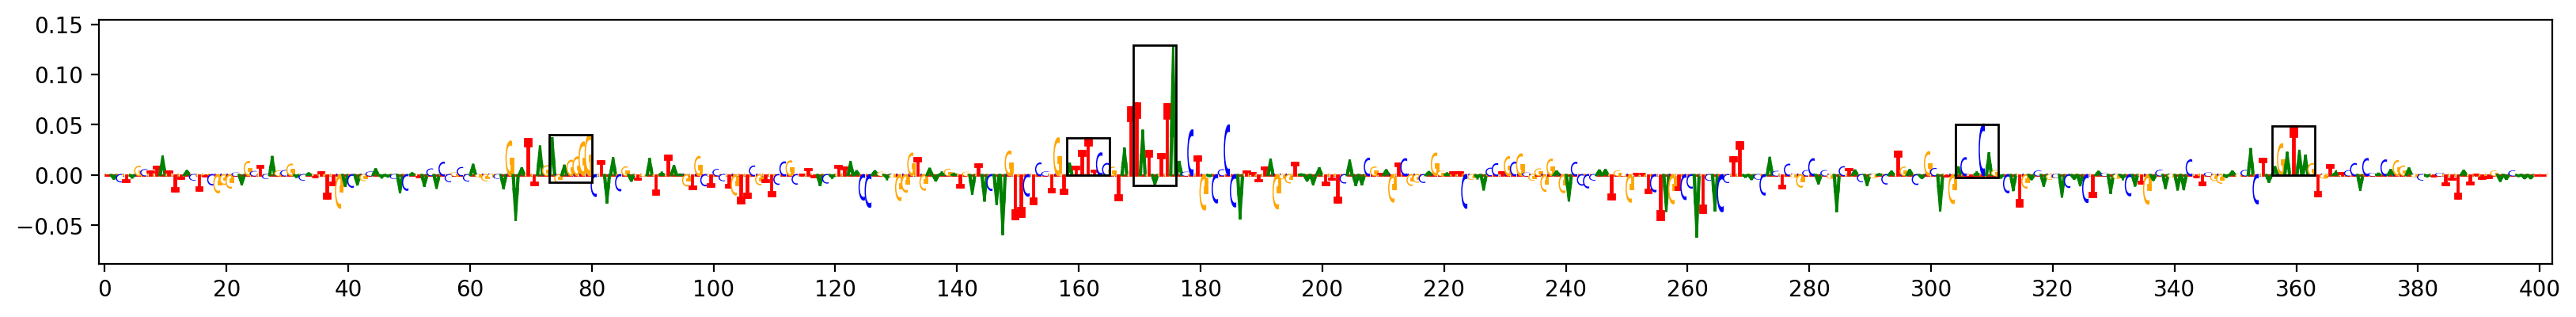

Computing windowed sums on original
Only returning positive coords!
Got 5 coords
Original core seqlet locations


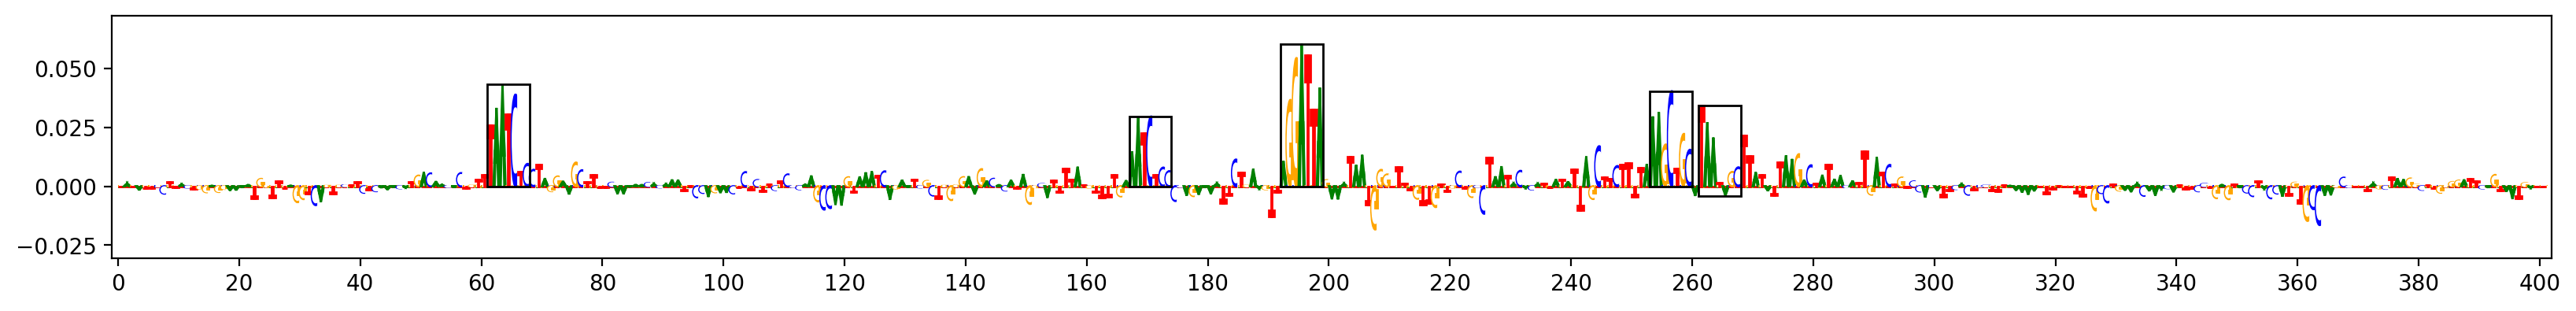

Computing windowed sums on original
Only returning positive coords!
Got 6 coords
Original core seqlet locations


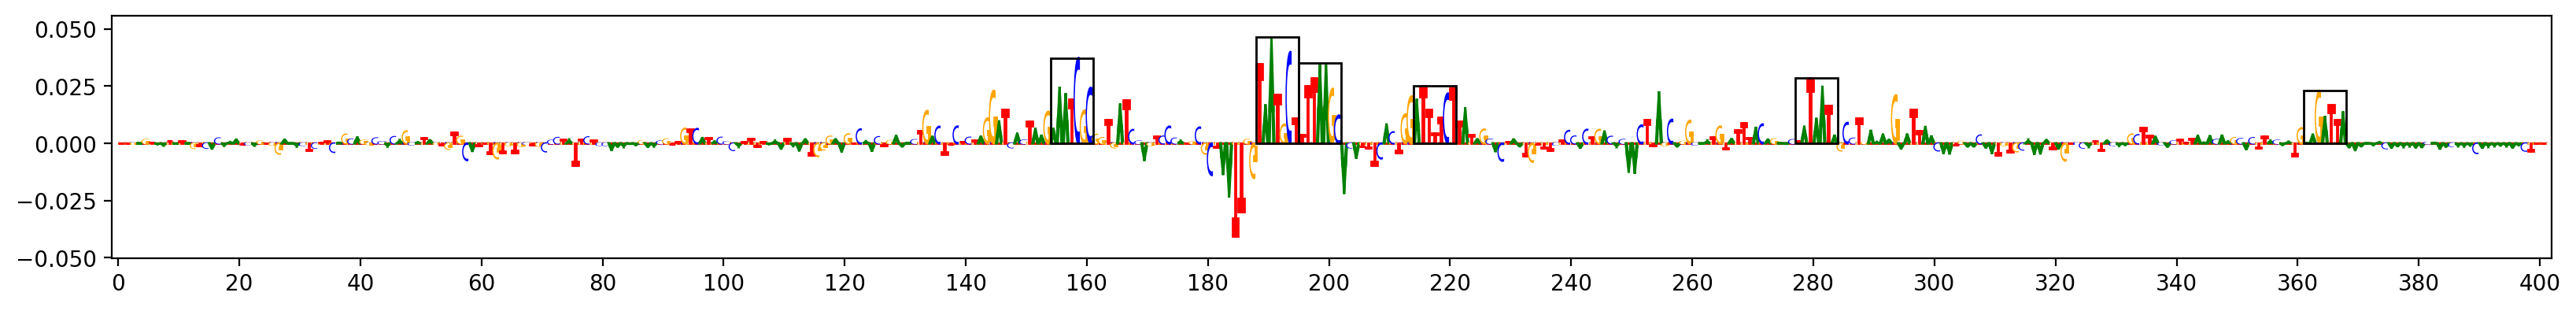

Computing windowed sums on original
Only returning positive coords!
Got 2 coords
Original core seqlet locations


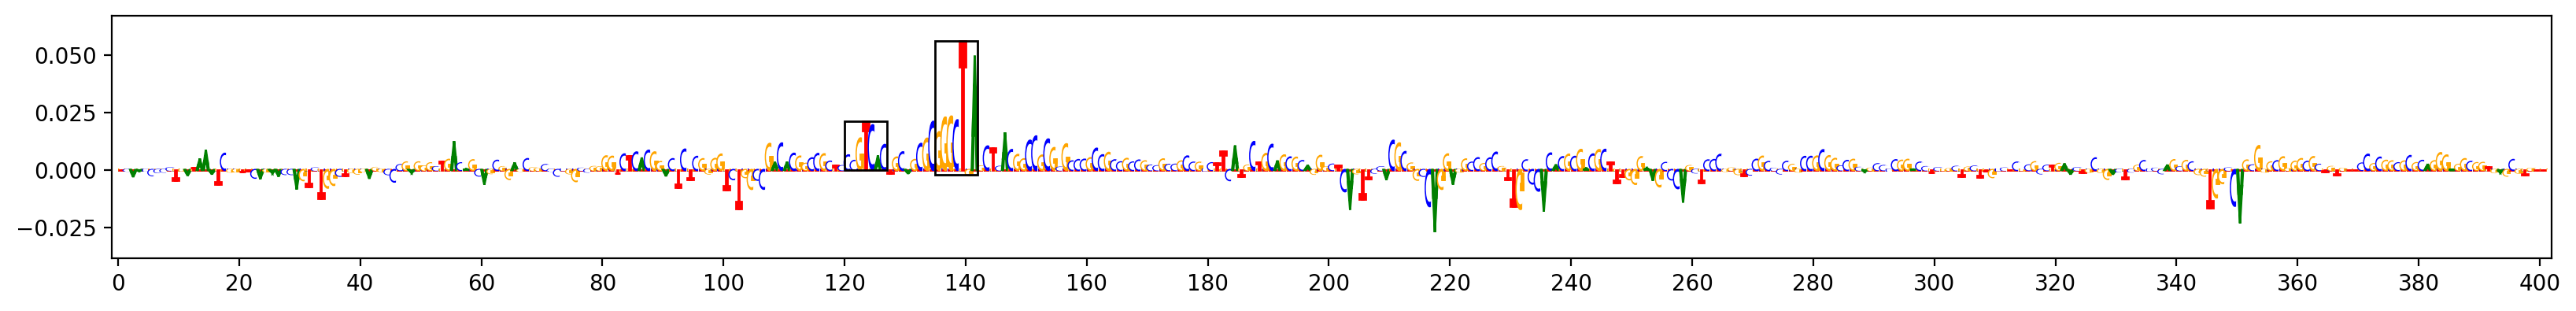

Computing windowed sums on original
Only returning positive coords!
Got 1 coords
Original core seqlet locations


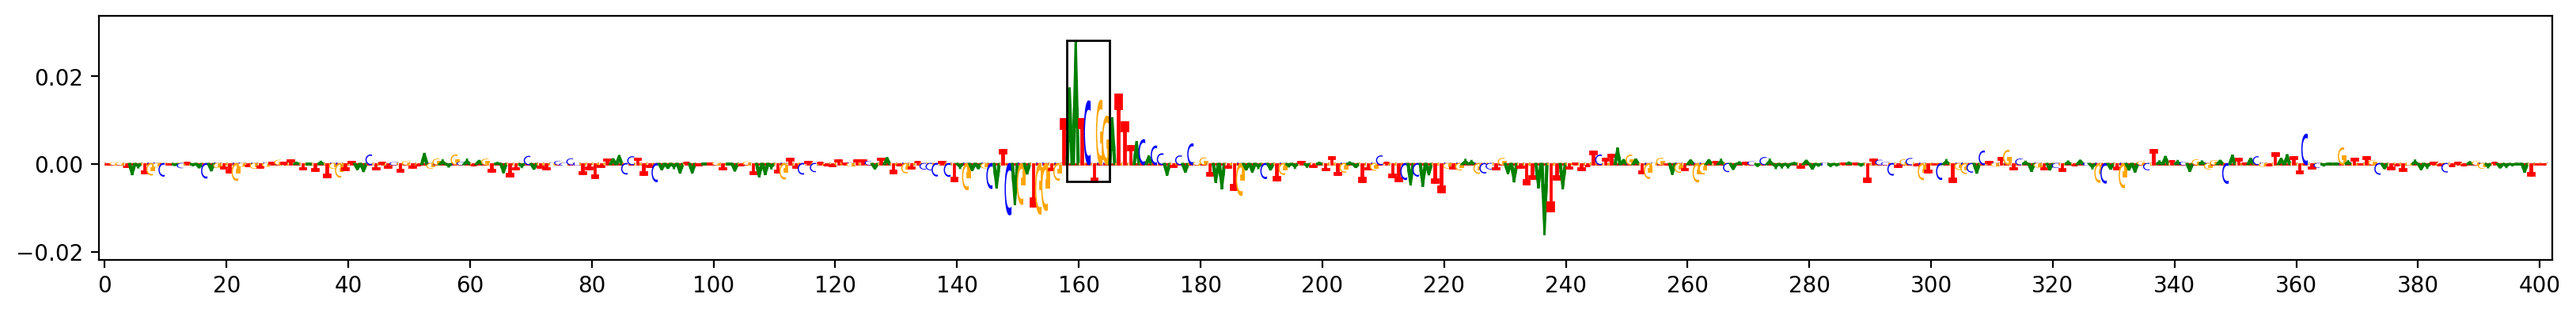

Computing windowed sums on original
Only returning positive coords!
Got 17 coords
Original core seqlet locations


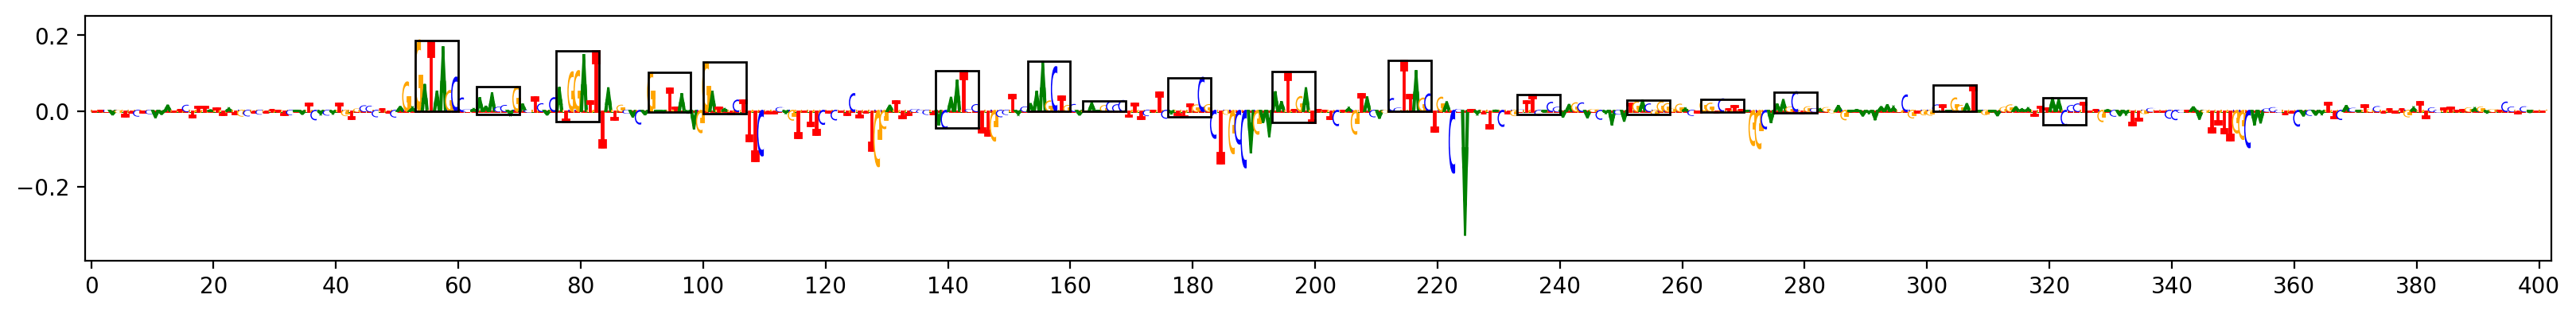

Computing windowed sums on original
Only returning positive coords!
Got 17 coords
Original core seqlet locations


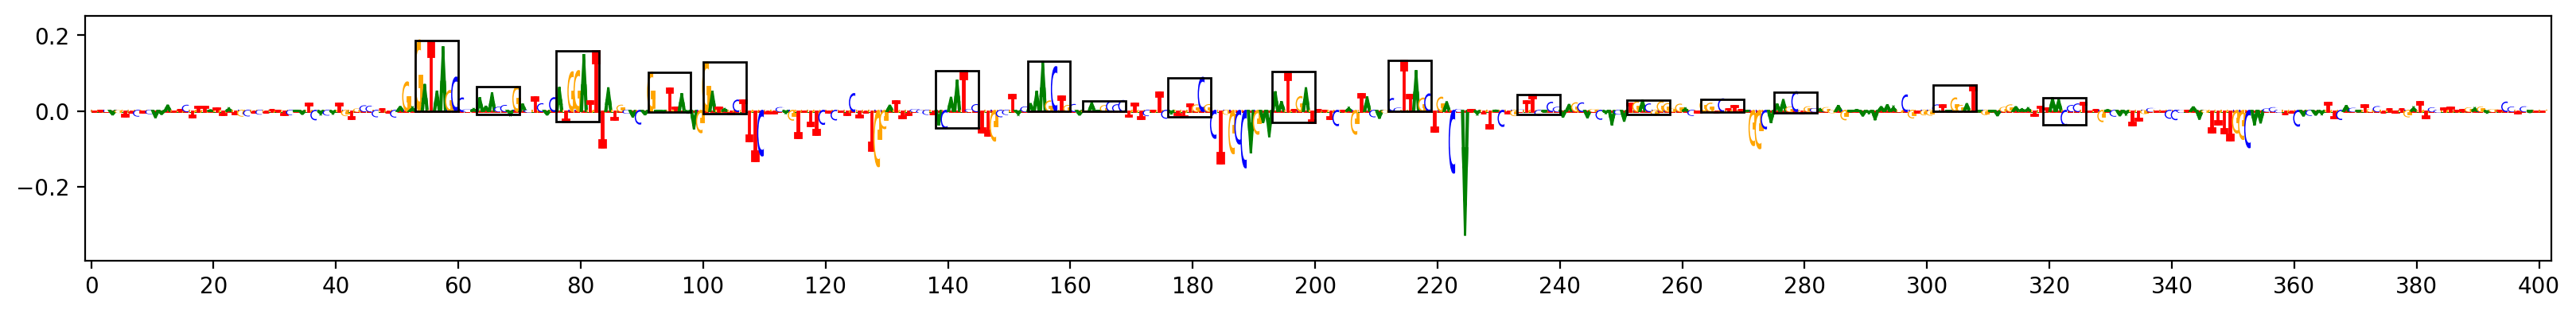

Computing windowed sums on original
Only returning positive coords!
Got 3 coords
Original core seqlet locations


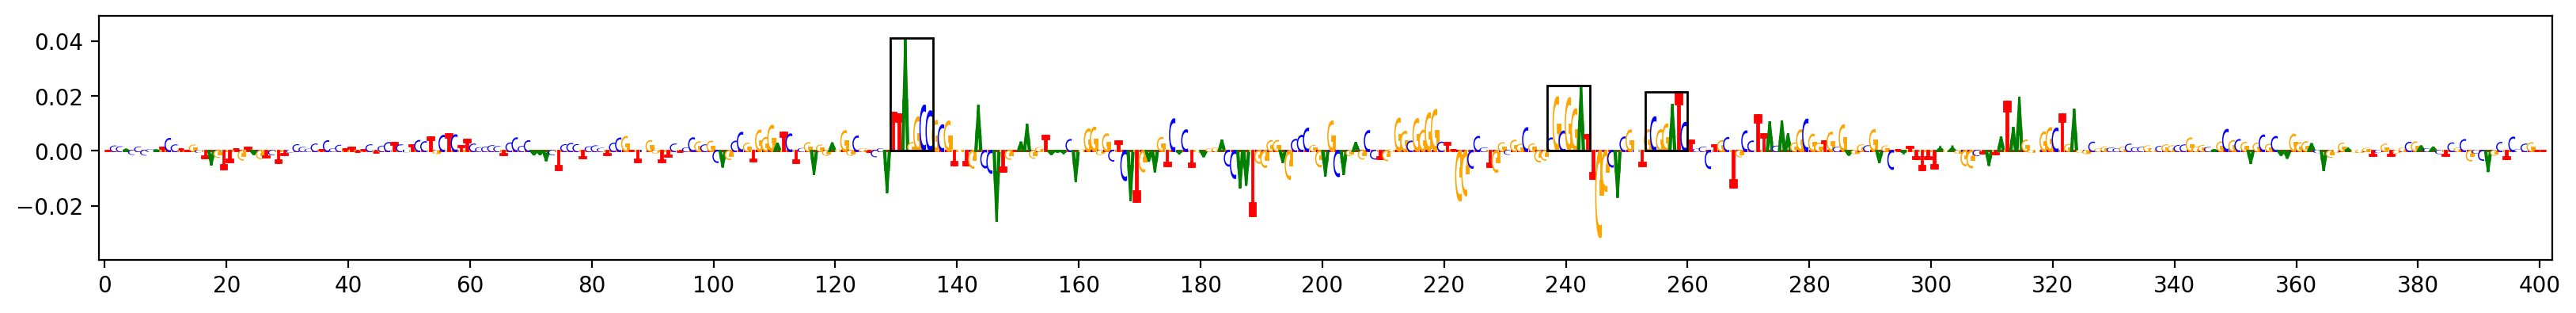

Computing windowed sums on original
Only returning positive coords!
Got 15 coords
Original core seqlet locations


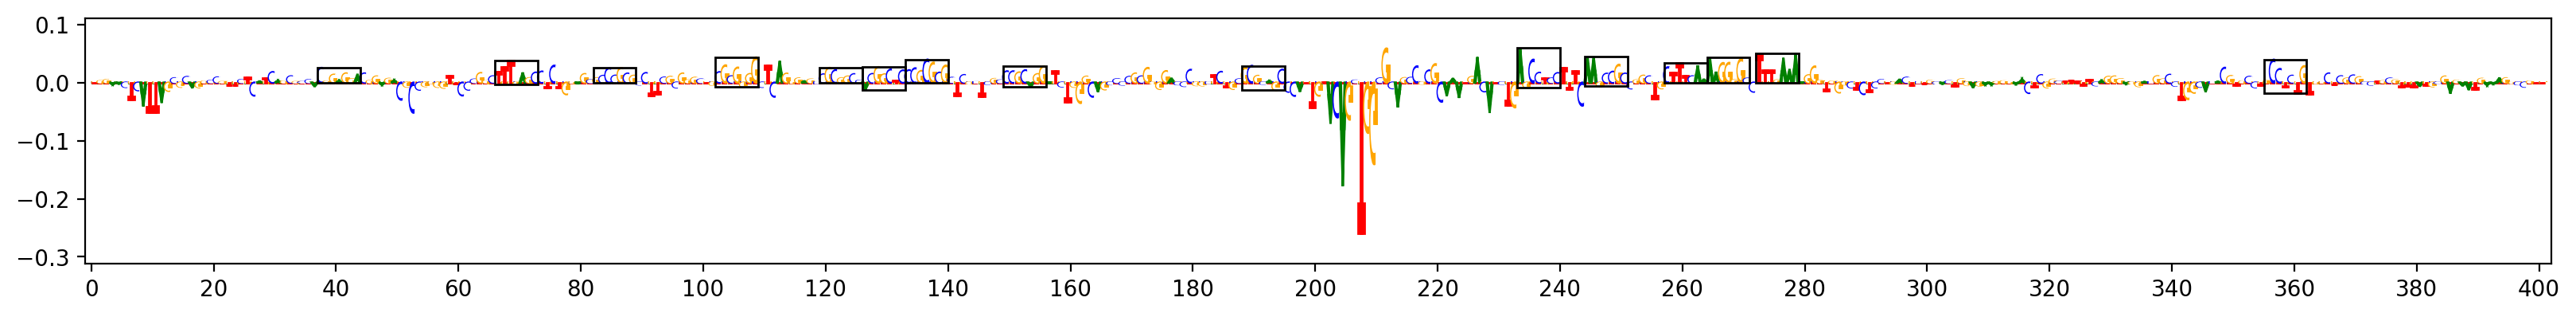

Computing windowed sums on original
Only returning positive coords!
Got 15 coords
Original core seqlet locations


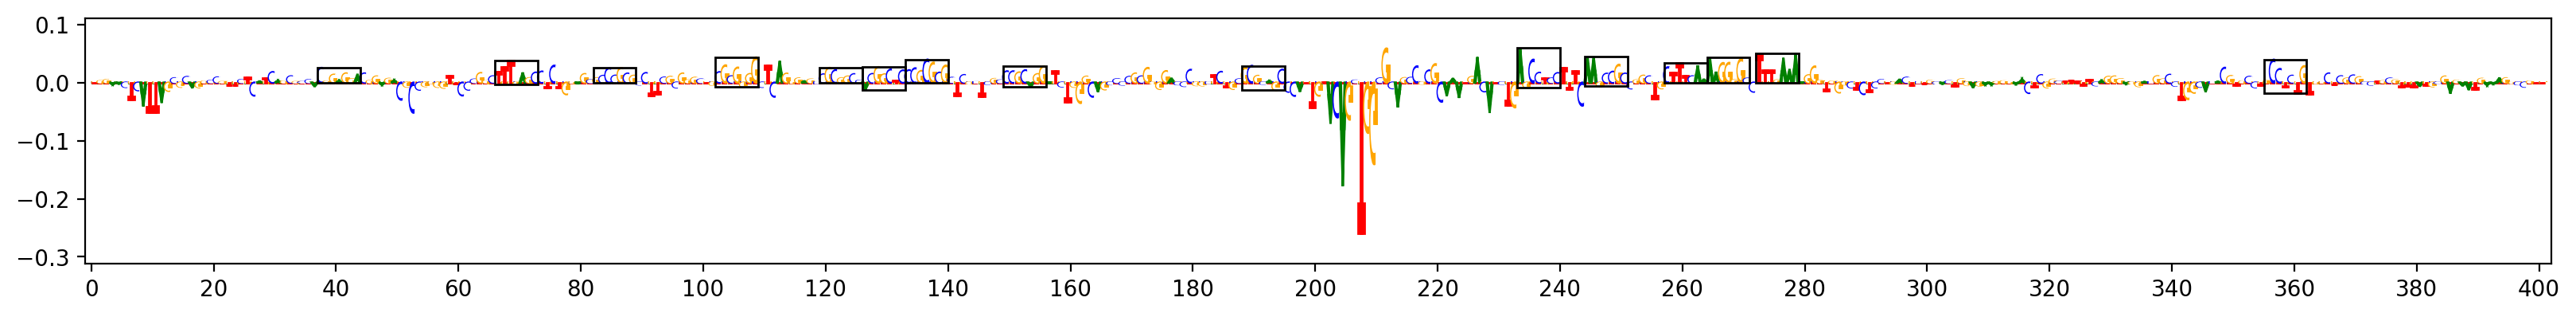

Computing windowed sums on original
Only returning positive coords!
Got 9 coords
Original core seqlet locations


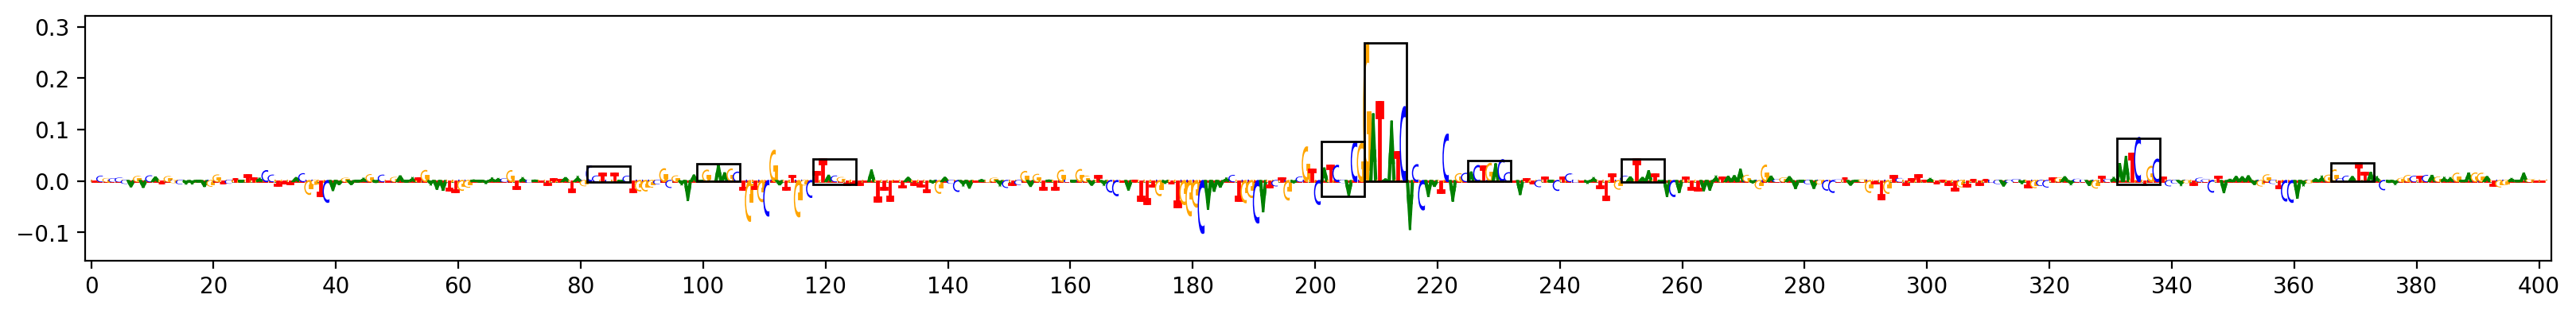

Computing windowed sums on original
Only returning positive coords!
Got 21 coords
Original core seqlet locations


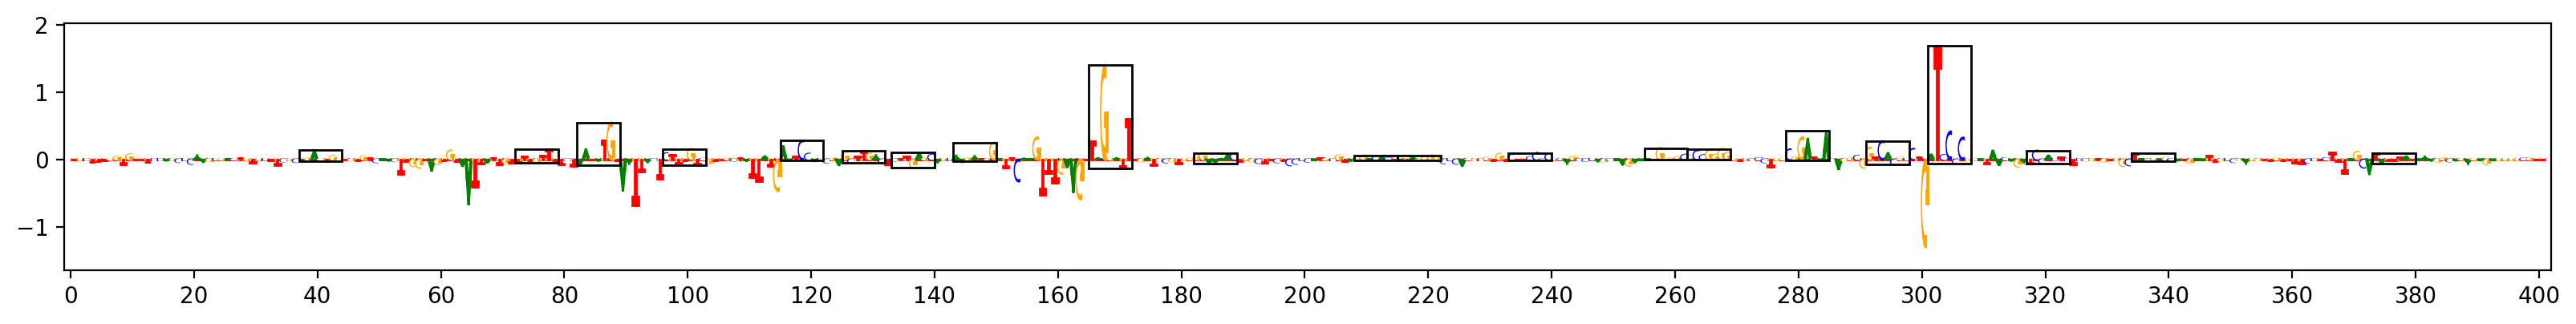

Computing windowed sums on original
Only returning positive coords!
Got 5 coords
Original core seqlet locations


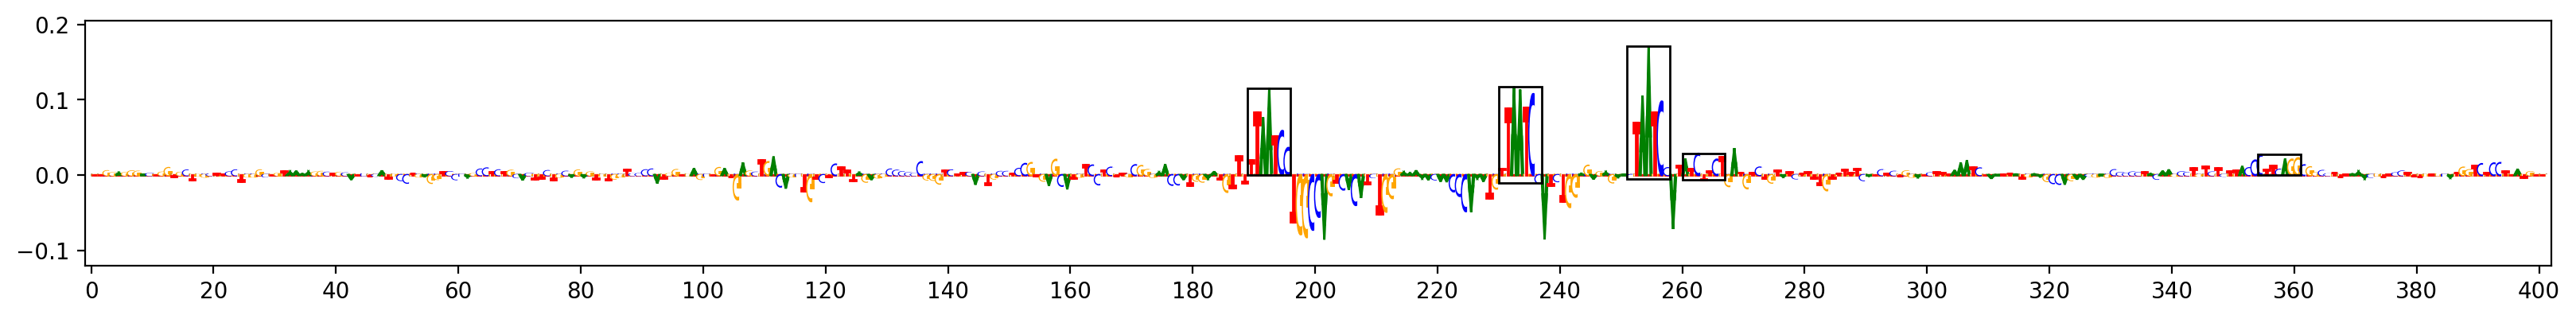

In [90]:
#visualize the matches
for match in patternidx_to_matches[0]: #visualizing the matches in the first 10 seqs
    
    exampleidx = match.exampleidx
    
    coords = hit_scorer.coordproducer(score_track=np.sum(contrib_scores[exampleidx], axis=-1)[None,:],
                                     tnt_results=hit_scorer.tnt_results, null_track=None).coords
    #highlight the locations of all the matches
    print("Original core seqlet locations")
    viz_sequence.plot_weights(
        contrib_scores[exampleidx],
        highlight={'black': [
            (max(x.start+hit_scorer.coordproducer.flank,0),
             min(x.end-hit_scorer.coordproducer.flank,len(contrib_scores[exampleidx])))
             for x in coords]},
        subticks_frequency=20)
#     print("Motif matches (red = without trimming)")
#     viz_sequence.plot_weights(
#         contrib_scores[exampleidx],
#         highlight={'red': [
#             (max(x.start,0), min(x.end,len(contrib_scores[exampleidx])))
#              for x in matches],
#                    'black': [
#             (max(x.trim_start,0), min(x.trim_end,len(contrib_scores[exampleidx])))
#              for x in matches]},
#         subticks_frequency=20)
    
#     for i in range(len(orig_patterns)):
#         matches_to_pattern = [x for x in matches if x.patternidx==i]
#         if (len(matches_to_pattern) > 0):
#             print("Matches to pattern",i,"(the original pattern looks like this:)")
#             viz_sequence.plot_weights(hit_scorer.seqlet_scorer.class_patterns[i]["task0_contrib_scores"].fwd)
#             viz_sequence.plot_weights(hit_scorer.seqlet_scorer.class_patterns[i]["sequence"].fwd)
#             print("matches in this example...")
#             for match in matches_to_pattern:
#                 print(match)
#                 if (match.is_revcomp==False):
#                     viz_sequence.plot_weights(contrib_scores[exampleidx][match.start:match.end])
#                 else:
#                     viz_sequence.plot_weights(contrib_scores[exampleidx][match.start:match.end][::-1,::-1])

In [96]:
?hit_scorer.tnt_results

Type:        FWACTransformAndThresholdResults
String form: <modisco.coordproducers.FWACTransformAndThresholdResults object at 0x14ccb98da2b0>
File:        ~/git_repos/tfmodisco/modisco/coordproducers.py
Docstring:   <no docstring>
